# Statistical foundations of Machine Learning

## INFO-F-422 House Prices project

Madalina Ciortan

May 11, 2017

## Overview

The current project aims at solving the House Prices Kaggle competition :https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In order to predict the house Sale Price, this report implements the following steps:
- data visualisation and exploration
- imputation
- creation of generic methods to assess model performance and for feature selection
- feature and model selection by comparing the results of running the above methods
- ensemble techniques
- prediction
- conclusion

In [58]:
suppressWarnings(suppressMessages(library(dummies)))
suppressWarnings(suppressMessages(library(ggplot2)))
suppressWarnings(suppressMessages(library(corrplot)))
library(rpart)
suppressWarnings(suppressMessages(library(e1071)))
library(lazy)
library(nnet)
suppressWarnings(suppressMessages(library(tree)))
library(ridge)

## Data overview and preprocessing

Load data sets:

In [4]:
input <- read.csv("./input/train.csv", stringsAsFactors = FALSE)
output <- read.csv("./input/test.csv", stringsAsFactors = FALSE)

dim(input)
dim(output)
print(paste('Output column :', setdiff(names(input), names(output))))

[1] 1460   81

[1] 1459   80

[1] "Output column : SalePrice"


In order to have a global perspective on the loaded data and to handle imputation for both input and test data, let's combine the input and output in one dataframe. This is achieved with rbind operator:

In [6]:
combined <- input 
combined$SalePrice <- NULL # remove sale price from train
combined <- rbind(combined, output)

Split data into numeric and categorical:

In [7]:
factor_variables<-which(sapply(combined[1,],class)=="character")

numeric.df<-combined[,-factor_variables]
categoric.df<-combined[,factor_variables]

### Categorical data visualisation, imputation and one hot encoding


The following method creates a histogram for showing the distribution of features at given indexes in given data_in input data frame:

In [8]:
plotHist <- function(data_in, positions) {
  for (i in positions) {
    if(class(data_in[[i]]) == "character") {
      barplot(prop.table(table(data_in[[i]])), xlab = colnames(data_in)[i], main = paste('Barplot ' , i))
    }else{
      hist(data_in[[i]],freq=FALSE, xlab = colnames(data_in)[i], main = paste('histogram ' , i))
      lines(density(data_in[[i]]), col ='blue')
    }
  }
}


Let's render the distribution of all categorical features:

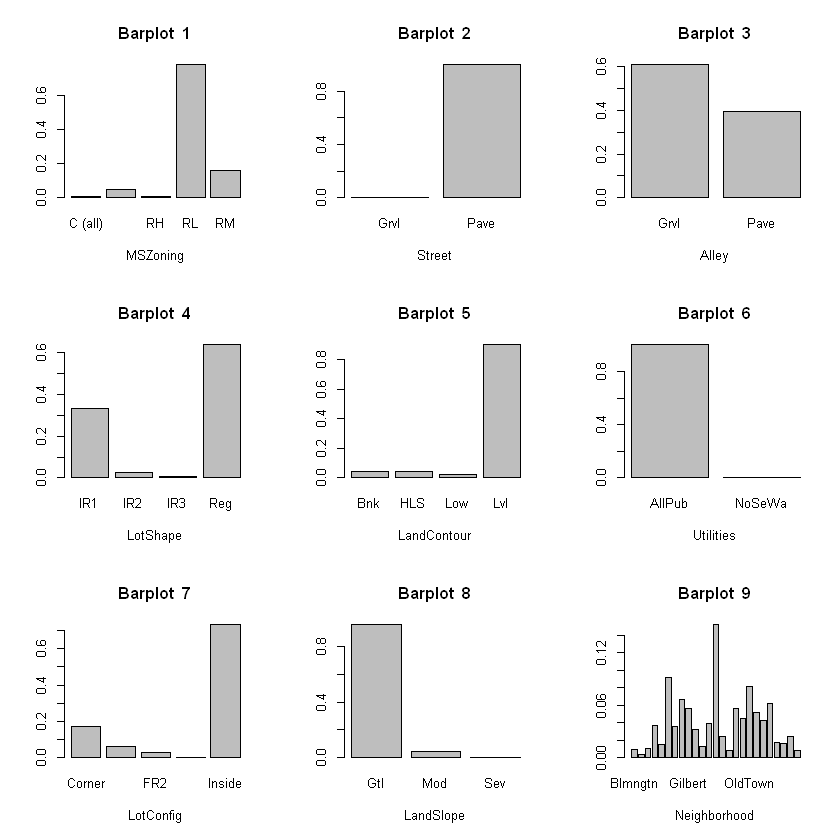

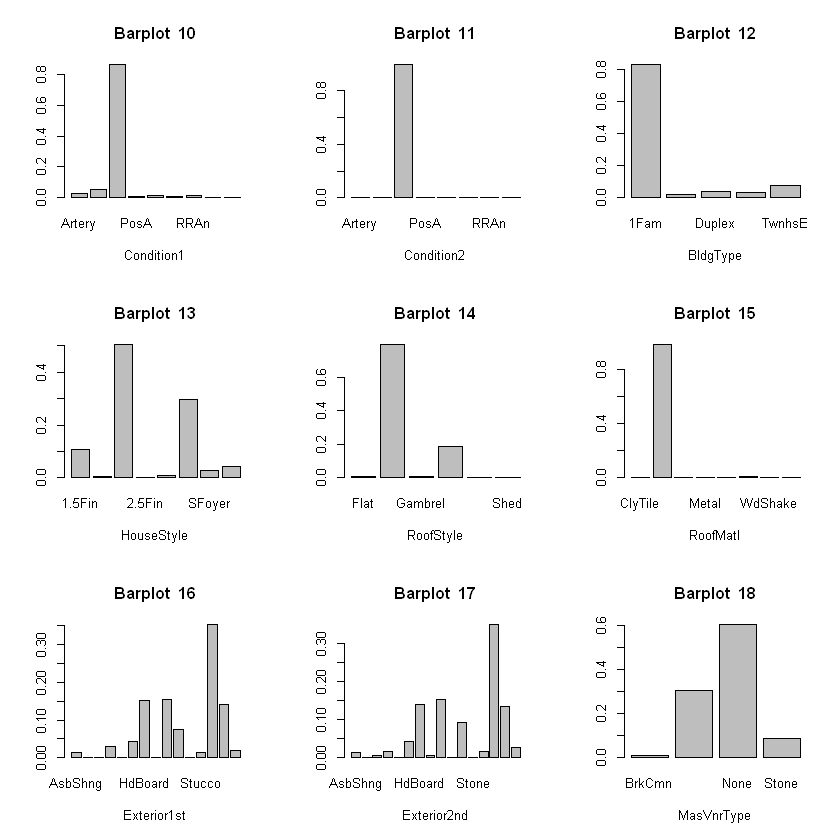

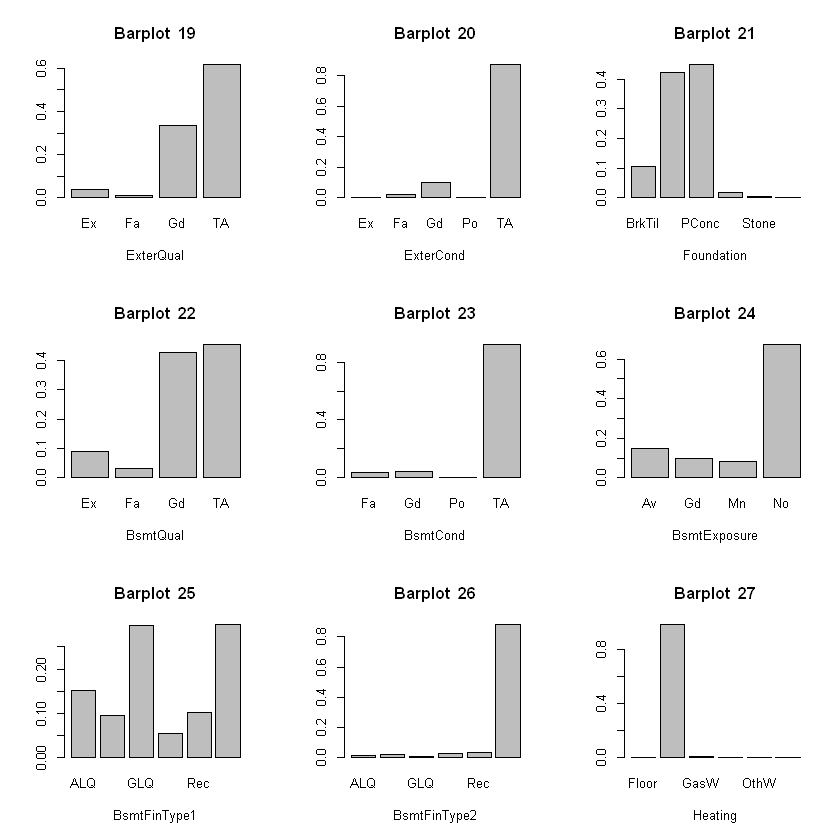

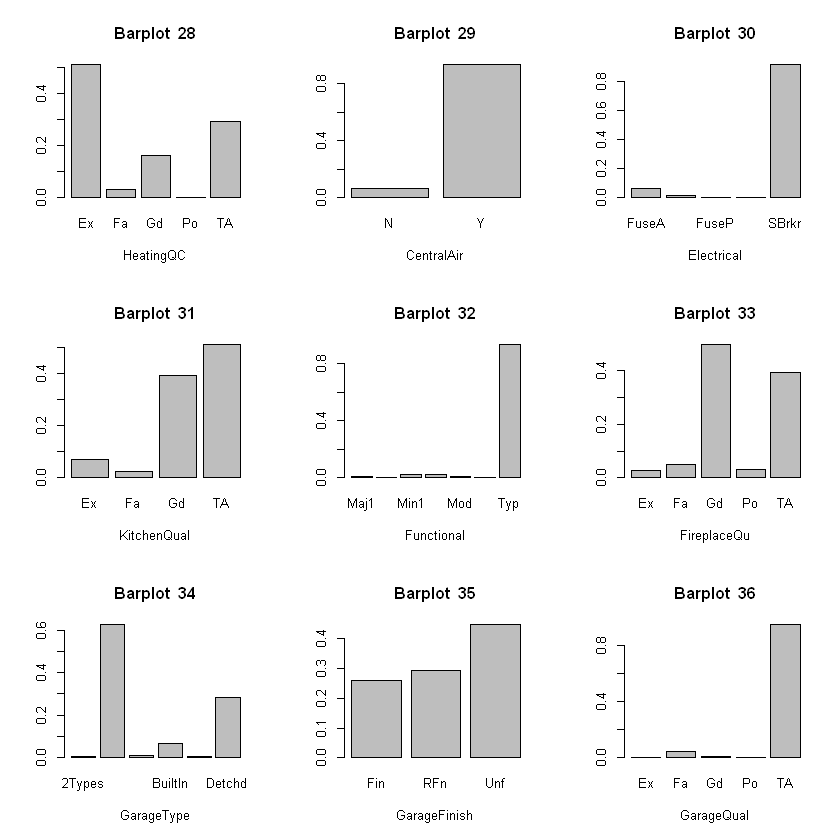

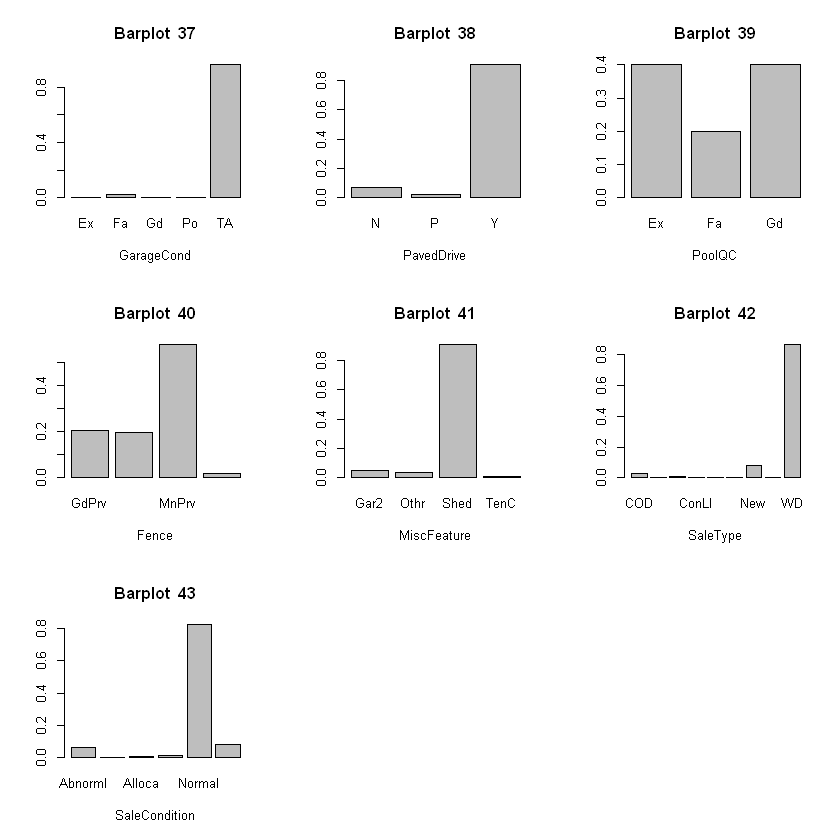

In [9]:
par(mfrow=c(3,3))
plotHist(categoric.df, 1:ncol(categoric.df))

By looking at the histograms for categorical data remove all feature where most values fall into 1 cat:

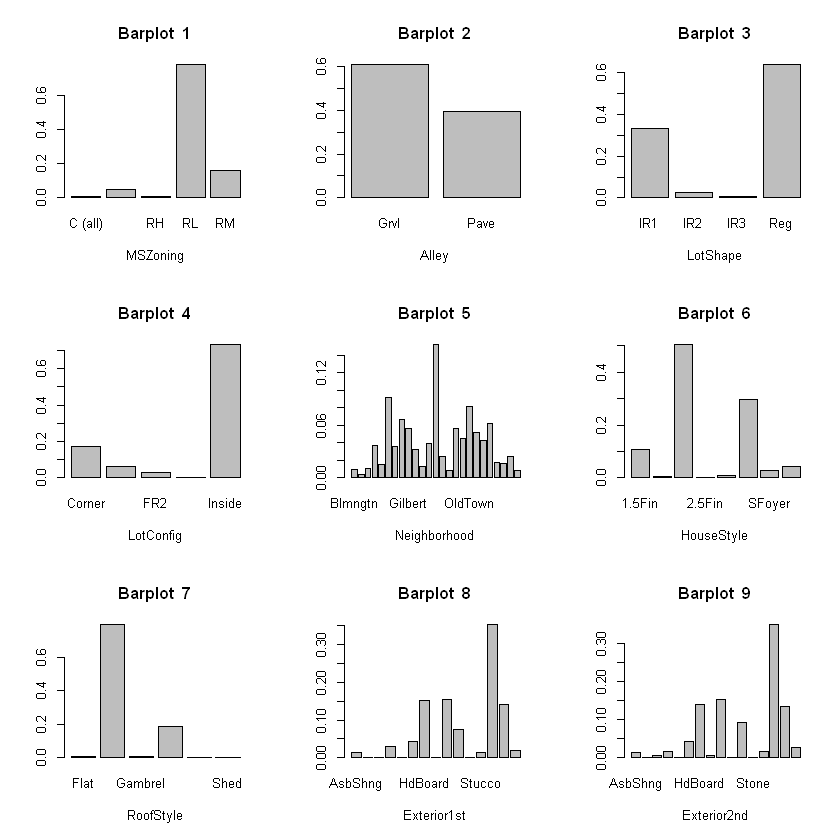

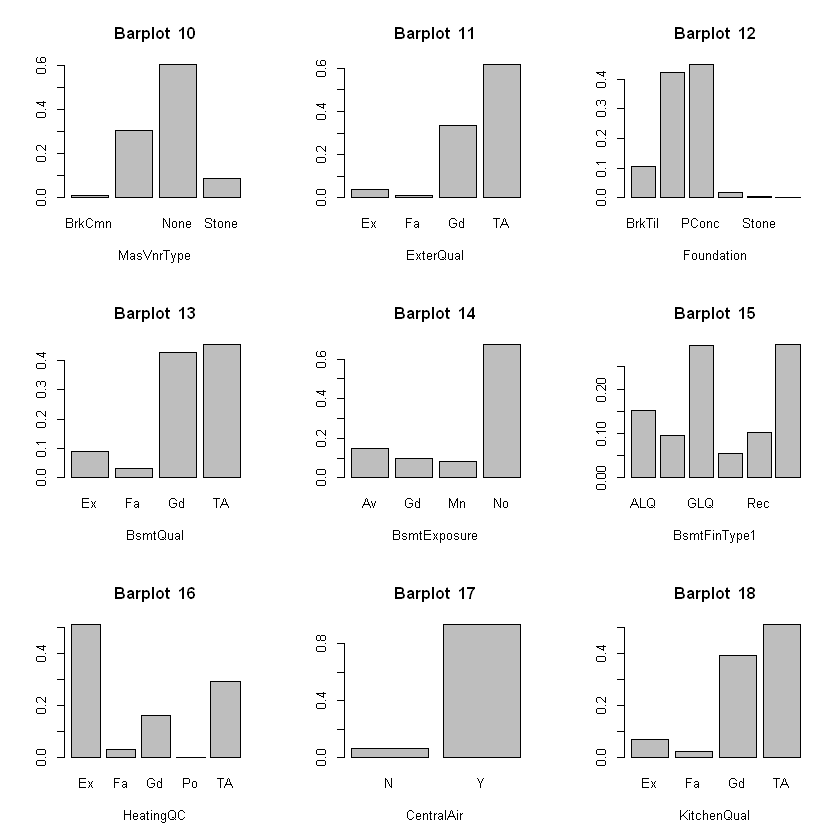

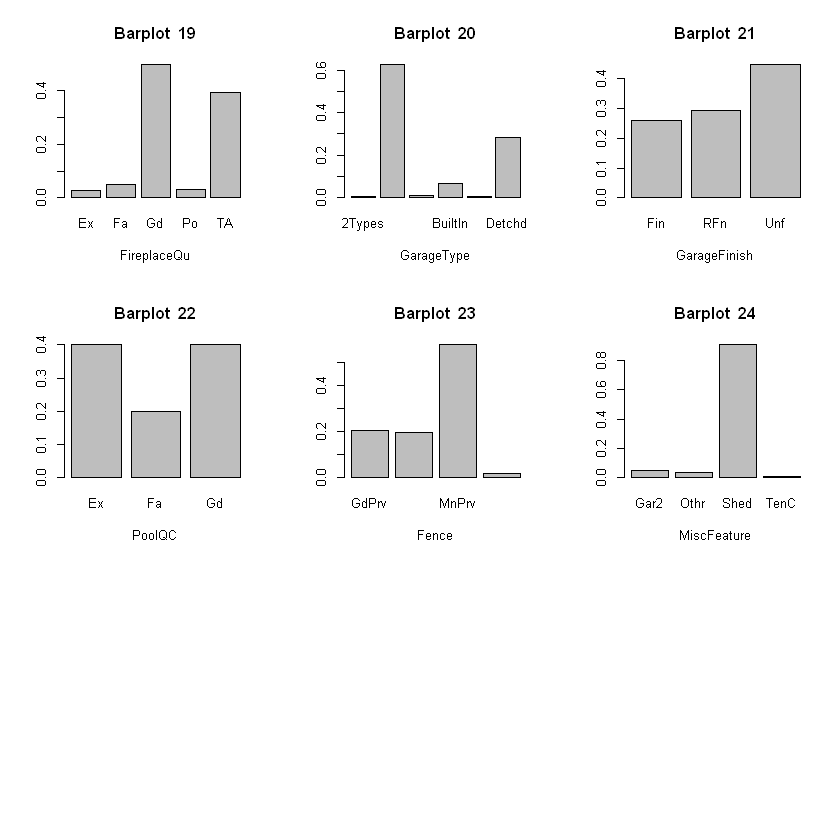

In [10]:
one_dominant_feature <- c('Street',"LandContour","Utilities", "LandSlope", 'Condition1', 'Condition2', 'BldgType', 'RoofMatl',
                          'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'Electrical', 'Functional', 'GarageQual',
                          "GarageCond","PavedDrive" , "SaleType" , "SaleCondition")

categoric.df <- categoric.df[,setdiff(names(categoric.df), one_dominant_feature)]
par(mfrow=c(3,3))
plotHist(categoric.df, 1: ncol(categoric.df))

Remove all features for which we don't have enough data:

In [11]:
not_enough_data <- c('MiscFeature', 'Fence', 'PoolQC', 'FireplaceQu', 'GarageFinish', 'BsmtQual', 'BsmtExposure', 
                     'BsmtFinType1', 'MasVnrType', 'GarageType', 'CentralAir' , 'Alley')

categoric.df <- categoric.df[,setdiff(names(categoric.df), not_enough_data)]


colSums(is.na(categoric.df))

MSZoning     LotShape    LotConfig Neighborhood   HouseStyle    RoofStyle 
           4            0            0            0            0            0 
 Exterior1st  Exterior2nd    ExterQual   Foundation    HeatingQC  KitchenQual 
           1            1            0            0            0            1

Impute missing values with the most frequent value on the column:


In [12]:
categoric.df[is.na(categoric.df$MSZoning), 'MSZoning'] <-names(sort(table(categoric.df$MSZoning), decreasing = TRUE)[1])
categoric.df[is.na(categoric.df$Exterior1st), 'Exterior1st'] <-names(sort(table(categoric.df$Exterior1st), decreasing = TRUE)[1])
categoric.df[is.na(categoric.df$Exterior2nd), 'Exterior2nd'] <-names(sort(table(categoric.df$Exterior2nd), decreasing = TRUE)[1])
categoric.df[is.na(categoric.df$KitchenQual), 'KitchenQual'] <-names(sort(table(categoric.df$KitchenQual), decreasing = TRUE)[1])


#Make sure there are no missing values
colSums(is.na(categoric.df))

MSZoning     LotShape    LotConfig Neighborhood   HouseStyle    RoofStyle 
           0            0            0            0            0            0 
 Exterior1st  Exterior2nd    ExterQual   Foundation    HeatingQC  KitchenQual 
           0            0            0            0            0            0

One hot encoding phase:

In [14]:
dim(categoric.df)

#one hot encoding phase
data_factor_onehot <- dummy.data.frame(categoric.df, sep="_")
dim(data_factor_onehot)

[1] 2919   12

[1] 2919  103

Make sure that we have valid column names as we are going to use this dataset for training.

Some packages like lazy or tree fail to process dataframe with column names containing spaces.

In [18]:
names(data_factor_onehot) <- make.names(names(data_factor_onehot), unique=TRUE)

### Numeric data visualisation and imputation 

In [19]:
colSums(is.na(numeric.df))
numeric.df$Id <-NULL #remove id

Id    MSSubClass   LotFrontage       LotArea   OverallQual 
            0             0           486             0             0 
  OverallCond     YearBuilt  YearRemodAdd    MasVnrArea    BsmtFinSF1 
            0             0             0            23             1 
   BsmtFinSF2     BsmtUnfSF   TotalBsmtSF     X1stFlrSF     X2ndFlrSF 
            1             1             1             0             0 
 LowQualFinSF     GrLivArea  BsmtFullBath  BsmtHalfBath      FullBath 
            0             0             2             2             0 
     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd    Fireplaces 
            0             0             0             0             0 
  GarageYrBlt    GarageCars    GarageArea    WoodDeckSF   OpenPorchSF 
          159             1             1             0             0 
EnclosedPorch    X3SsnPorch   ScreenPorch      PoolArea       MiscVal 
            0             0             0             0             0 
       MoSold        YrSold 
            0             0

Let's find relationships between features.

All basement features seem to be related

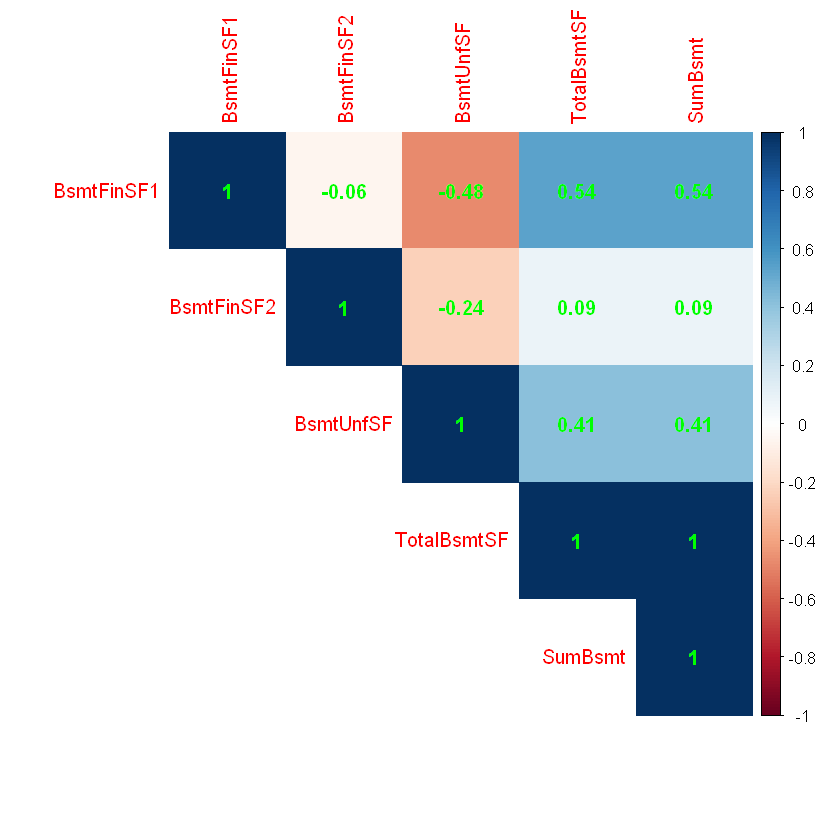

In [20]:
if( 'BsmtFinSF1' %in% names(numeric.df) ){
    bsmt <- numeric.df[, c('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF')]
    bsmt$SumBsmt <- bsmt$BsmtFinSF1 + bsmt$BsmtFinSF2 + bsmt$BsmtUnfSF
    par(mfrow=c(1,1))
    corrplot(cor(bsmt,use="complete.obs"),type = 'upper', method='color', addCoef.col = 'green')
    #because TotalBsmtSF is totally corellated with the sum of 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF' we
    #can simplify our model by keeping just the total
    numeric.df$BsmtFinSF1 <- NULL  
    numeric.df$BsmtFinSF2 <- NULL 
    numeric.df$BsmtUnfSF <- NULL 
}


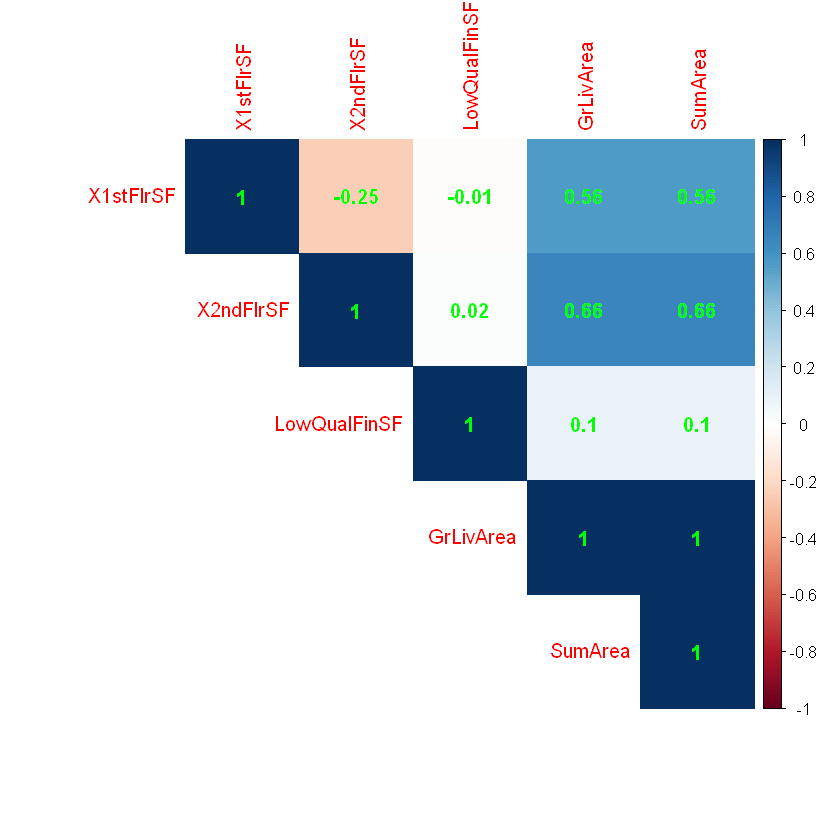

In [21]:
#Ground area surfaces also seem to be related
if( 'X1stFlrSF' %in% names(numeric.df) ){
    area <- numeric.df[, c('X1stFlrSF', 'X2ndFlrSF', 'LowQualFinSF', 'GrLivArea')]
    area$SumArea <- area$X1stFlrSF + area$X2ndFlrSF + area$LowQualFinSF
    par(mfrow=c(1,1))
    corrplot(cor(area,use="complete.obs"),type = 'upper', method='color', addCoef.col = 'green')
    #because GrLivArea is totally corellated with the sum of 'X1stFlrSF', 'X2ndFlrSF', 'LowQualFinSF' we
    #can simplify our model by keeping just the total
    numeric.df$X1stFlrSF <- NULL  
    numeric.df$X2ndFlrSF <- NULL 
    numeric.df$LowQualFinSF <- NULL 
}

In [22]:
#Remove features with a lot of missing data
numeric.df$LotFrontage <- NULL
numeric.df$GarageYrBlt <- NULL

In [23]:
#For remaining features let's impute with mean
replace_na_with_mean_value <- function(vec) {
  mean_vec <- mean(vec, na.rm = TRUE)
  vec[is.na(vec)] <- mean_vec
  vec
}


numeric.df <- data.frame(apply(numeric.df, 2, replace_na_with_mean_value))

At this point we have no missing data!

In [24]:
colSums(is.na(numeric.df))

MSSubClass       LotArea   OverallQual   OverallCond     YearBuilt 
            0             0             0             0             0 
 YearRemodAdd    MasVnrArea   TotalBsmtSF     GrLivArea  BsmtFullBath 
            0             0             0             0             0 
 BsmtHalfBath      FullBath      HalfBath  BedroomAbvGr  KitchenAbvGr 
            0             0             0             0             0 
 TotRmsAbvGrd    Fireplaces    GarageCars    GarageArea    WoodDeckSF 
            0             0             0             0             0 
  OpenPorchSF EnclosedPorch    X3SsnPorch   ScreenPorch      PoolArea 
            0             0             0             0             0 
      MiscVal        MoSold        YrSold 
            0             0             0

### Ouput overview

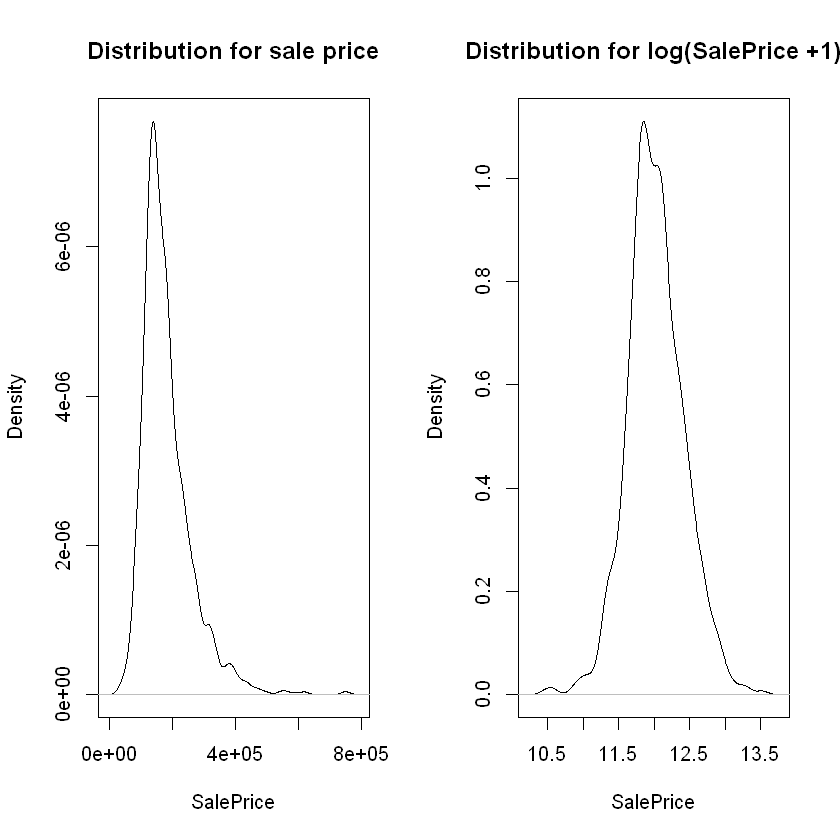

In [25]:
par(mfrow=c(1,2))
#let's examine the output
plot(density(input$SalePrice), xlab = 'SalePrice', 'Distribution for sale price') 
#the distribution of sale prices is right-skewed and does not follow a gaussian
plot(density(log(input$SalePrice + 1)), xlab = 'SalePrice', 'Distribution for log(SalePrice +1)')

In [26]:
#From the 103 one hot encoded variables only keep the ones at least slightly correlated with the output
cat.corr.df = cbind(data_factor_onehot[1:nrow(input),], SalePrice = Y)
cat.correlations <- abs(cor(cat.corr.df))

# only want the columns that show strong correlations with SalePrice, bigger than 0.2
cat.corr.SalePrice = as.matrix(sort(cat.correlations[,'SalePrice'], decreasing = TRUE))
cat.corr.idx = names(which(apply(cat.corr.SalePrice, 1, function(x) (x > 0.2))))
#corrplot(as.matrix(cat.correlations[cat.corr.idx ]), type = 'upper', method='color', addCoef.col = 'green')

correlated_data_factor_one_hot <-data_factor_onehot[, which(apply(cat.corr.SalePrice, 1, function(x) (x > 0.2)))]

dim(correlated_data_factor_one_hot)

#let's combine numeric and categorical into one dataset    
data <- cbind(numeric.df, correlated_data_factor_one_hot)

[1] 2919   25

In [27]:
X<- data[1:nrow(input),]
Y<-log(input$SalePrice + 1)
N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables

train<-cbind(X ,SalePrice=Y)
test <- data[(nrow(input) + 1):nrow(numeric.df),]


Let's check dependencies between features and SalePrice:


In [29]:
plotOutputDependency <- function(data_in, output, positions) {
  for (i in positions) {
    plot(data_in[[i]], output, xlab = colnames(data_in)[i], ylab = 'SalePrice', main = paste('Dependency ' , i))
  }
}

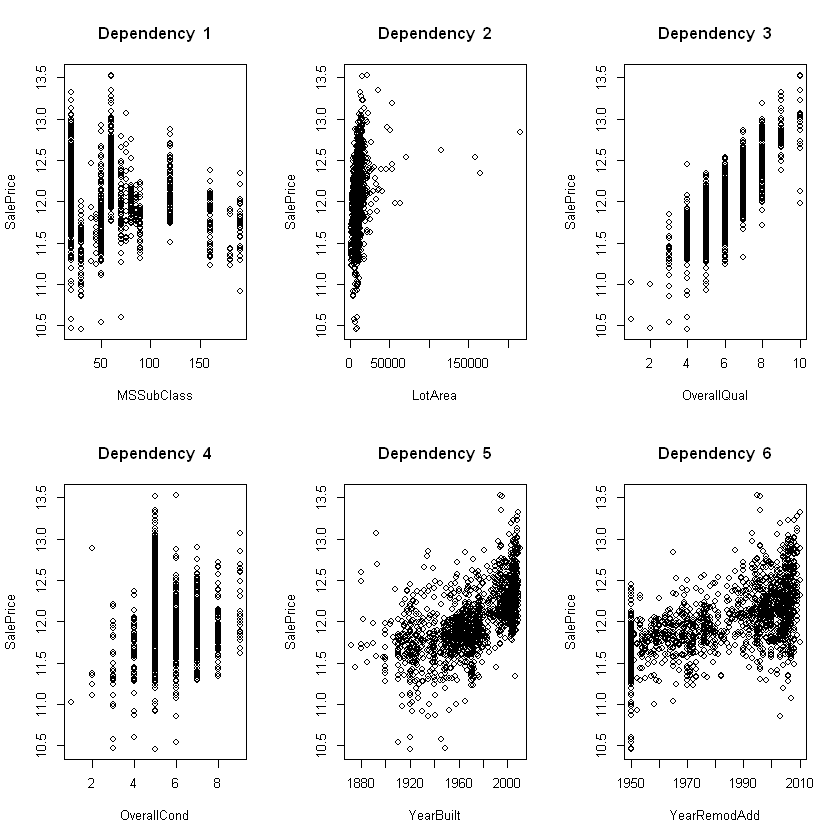

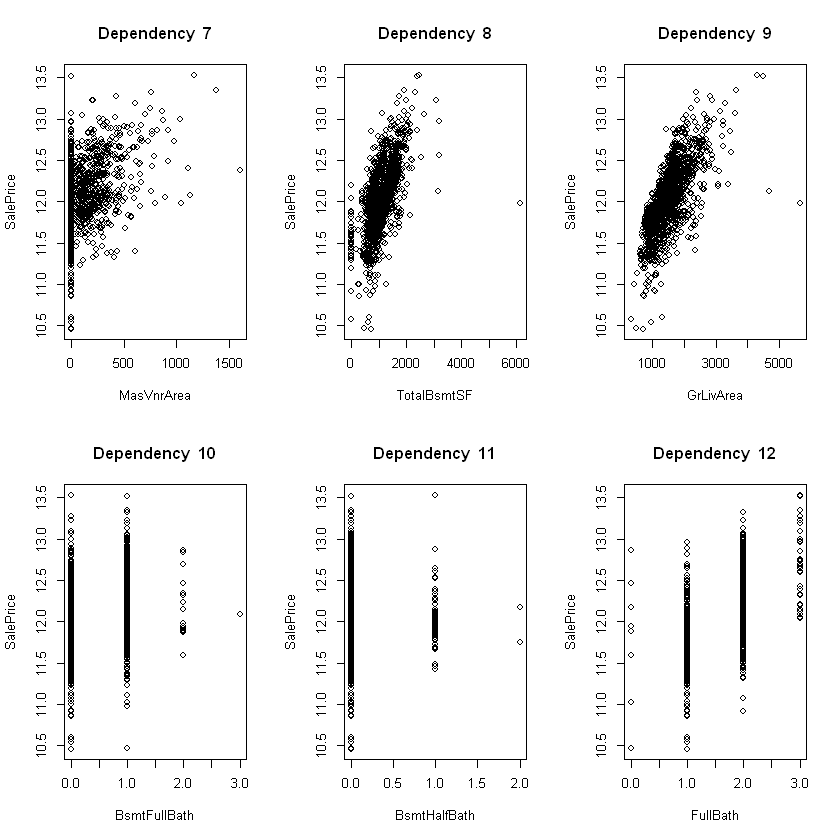

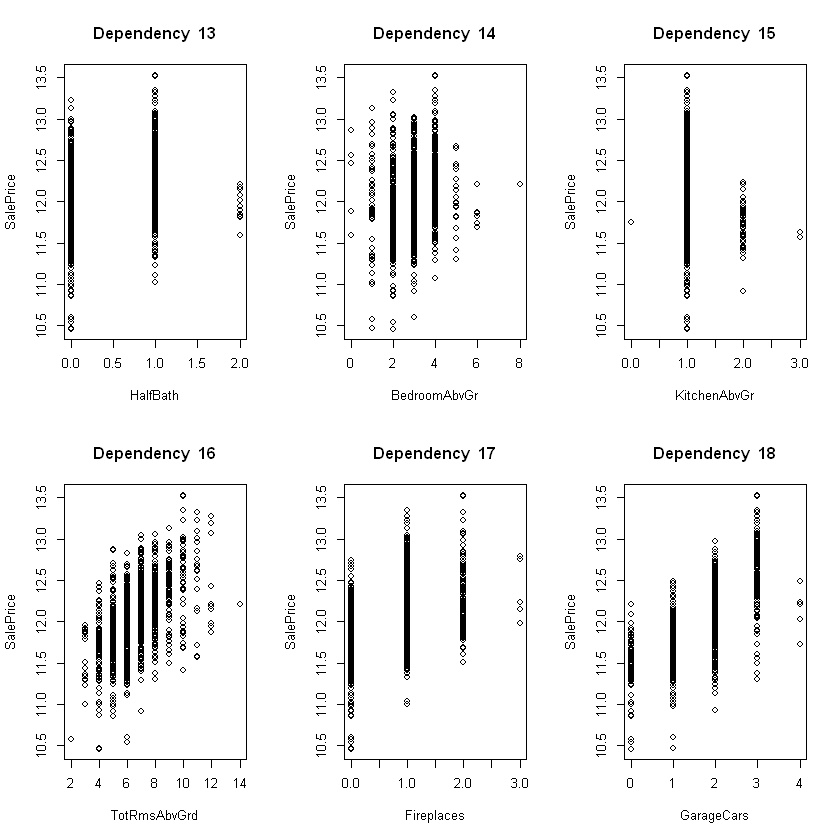

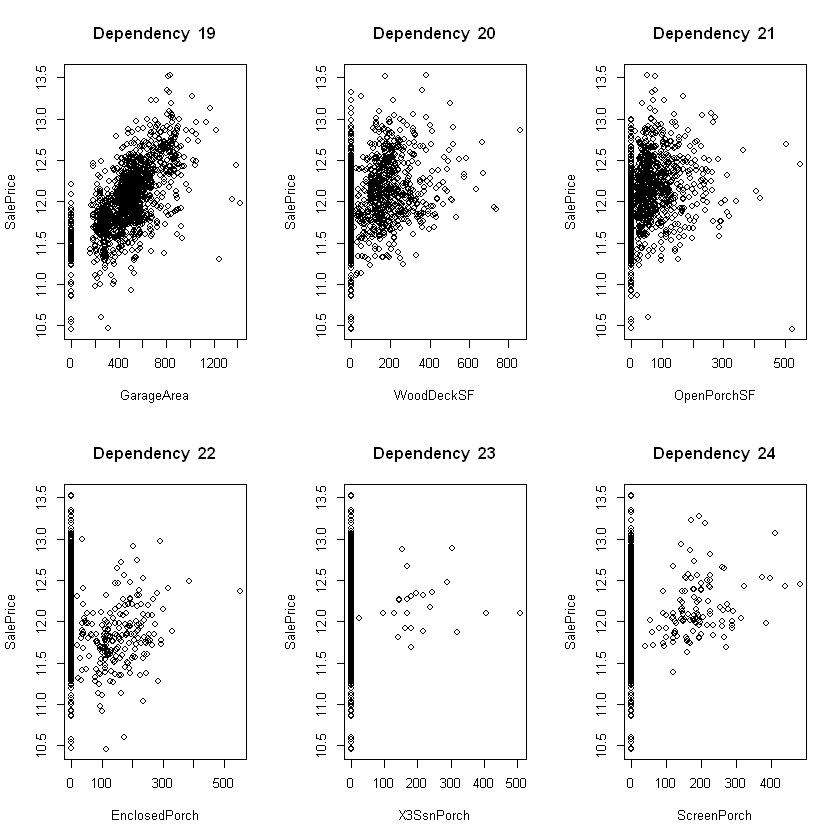

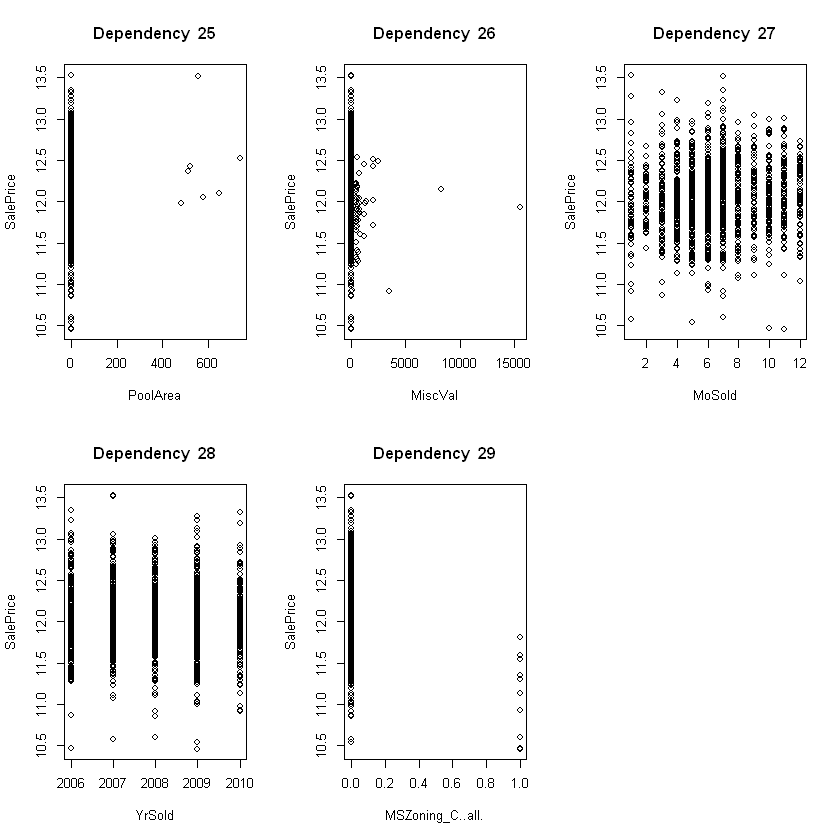

In [30]:
par(mfrow=c(2,3))
plotOutputDependency(X, Y, 1:29)

[1] 10

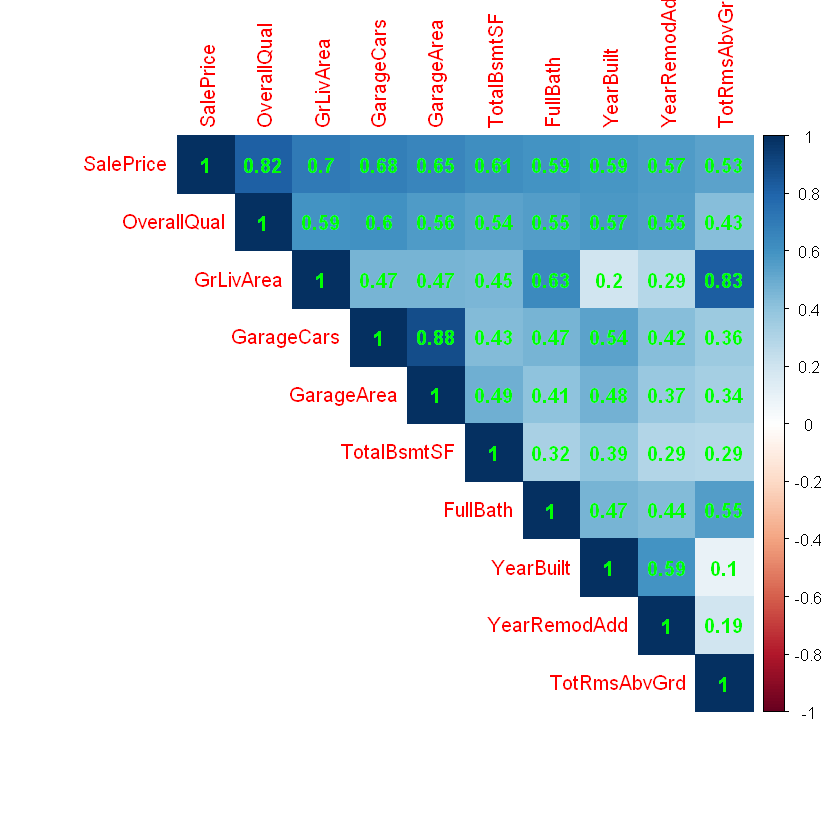

In [31]:
corr.df = cbind(X, SalePrice = Y)
correlations <- abs(cor(corr.df))

# only want the columns that show strong correlations with SalePrice, bigger than 0.5
corr.SalePrice = as.matrix(sort(correlations[,'SalePrice'], decreasing = TRUE))
corr.idx = names(which(apply(corr.SalePrice, 1, function(x) (x > 0.5))))

par(mfrow=c(1,1))
corrplot(as.matrix(correlations[corr.idx,corr.idx]), type = 'upper', method='color', addCoef.col = 'green')
    
length(corr.idx) #we have 10 features with a significative correlation with SalePrice


In [32]:
X<- data[1:nrow(input),]
Y<-log(input$SalePrice + 1)
N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables
    

In [34]:
dim(data) 

[1] 2919   53

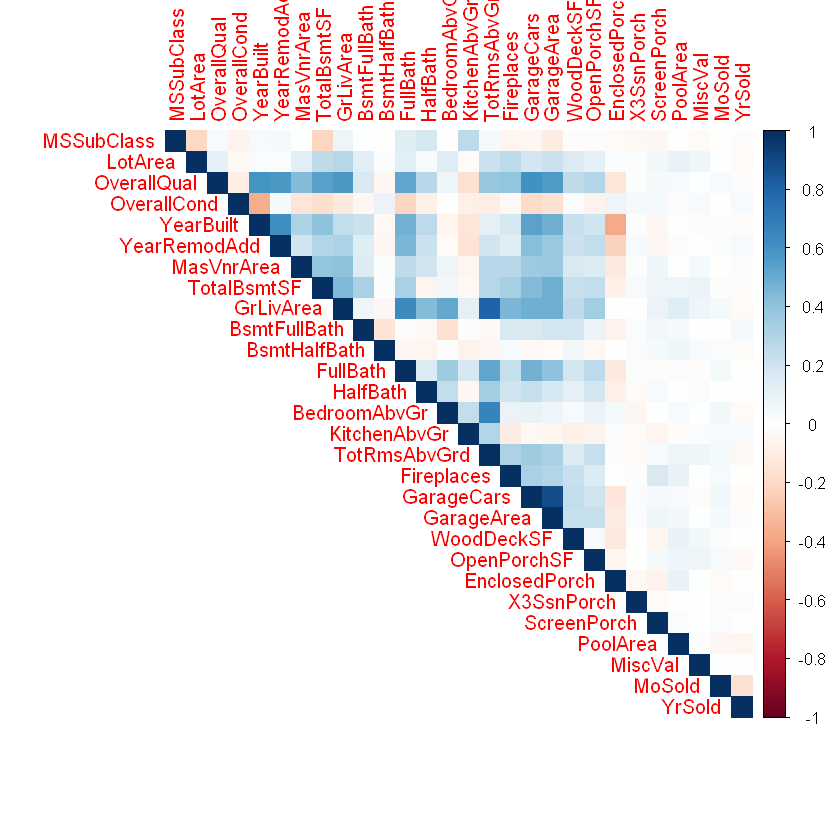

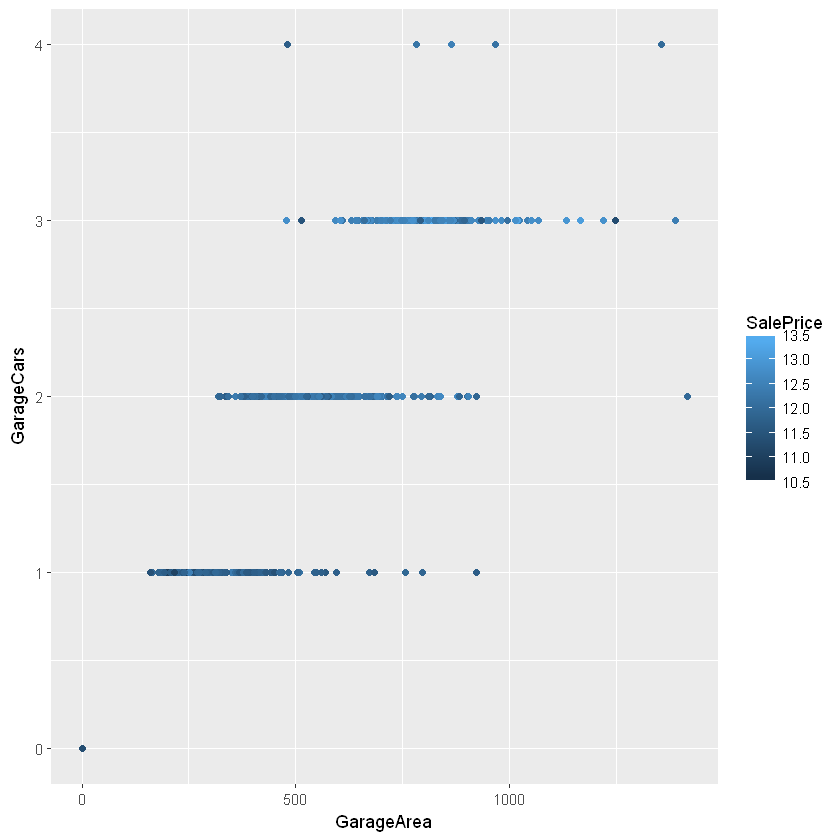

In [36]:
#Explore possible correlations between parameters
corrplot(cor(numeric.df,use="complete.obs"),type = 'upper', method='color')

ggplot(train, aes(x = GarageArea, y = GarageCars, color = SalePrice)) +
  geom_point() + scale_fill_brewer(palette = "Spectral")

There are some dependencies we can explore in order to reduce features, for instance GarageArea is liniarly dependent on GarageCars.

We can do the same thing for categorical data too.

The root mean squared error function between the logarithm of the predicted value and the logarithm of the observed sales price to evaluate model performance:

In [37]:
rmse <- function (log_prediction, log_observation){
  sqrt(mean(log_prediction-log_observation)^2)
}


## Feature selection


The following code performs features selection by keeping the most correlated variables with the output:

In [93]:

outputCorrelation <- function(modelName, X, Y){
  n <- ncol(X)
  size.CV<-floor(N/10)
  ranking <- numeric(n)
  CV.err<-matrix(0,nrow=n,ncol=10)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    
    
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]
    
    i.tr<-setdiff(1:N,i.ts)
    X.tr<-X[i.tr,]
    Y.tr<-Y[i.tr]
    
    #sometimes in the sampling process sd is 0 so let's remove those features because
    #calculating corelation on them would be a division by 0
    #X.tr <- X.tr[,which(apply(X.tr, 2, sd)!=0)]
    correlation<-abs(cor(X.tr,Y.tr))
    ranking<-sort(correlation,dec=T,index.return=T)$ix
    
    for (nb_features in 1:length(ranking)) {
      DS<-cbind(X.tr[,ranking[1:nb_features],drop=F],SalePrice=Y.tr)
      
      if(modelName == 'lm') {
        model<- lm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'rpart') {
        model<- rpart(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'tree') {
        model<- tree(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'svm'){
        # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
        #             shrinking = T, cross = 10, cost = 4, epislon = 0.2)
        model<- svm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'nnet'){
        #DS <- scale(DS)
        model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'lazy'){
        model<- lazy(SalePrice~.,DS)
        Y.hat.ts<- predict(model,X.ts[,ranking[1:nb_features],drop=F])$h
      }
      if(modelName == 'ridge'){
        model<- linearRidge(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      
      CV.err[nb_features,i]<-rmse(Y.hat.ts,Y.ts)
    }
  }  
  
  par(mfrow=c(1,1))
  plot(1:nrow(CV.err),apply(CV.err,1,mean), type = "o", main = paste(modelName ,' filter feature'), xlab = "number of features", ylab = 'cross validaton error' )
  
  writeLines(paste( modelName, " filter features: ",c(1:n)," ; CV error=",round(apply(CV.err,1,mean),digits=4), " ; std dev=",round(apply(CV.err,1,sd),digits=4)))
  ranking
}




The minimum redundancy maximum relevance feature selection strategy approximates


\begin{equation}
  \arg\max_{x_{k}\in X - X_{S}} \left(I\left\{X_{S}; x_{k}\right\};y\right)
\end{equation}


with


\begin{equation}
  x^*_{MRMR}=\arg\max_{x_{k}\in X - X_{S}} \left[I(x_{k}; y) - \frac{1}{m} \sum_{x_{i}\in X_{S}} I(x_{i}; x_{k})\right]
\end{equation}

where $m$ is the size of $X_S$


In [94]:
mrmr <- function(modelName, X, Y) {
  n <- ncol(X)
  size.CV<-floor(N/10)
  
  CV.err<-matrix(0,nrow=n,ncol=10)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)
    X.tr<-X[i.tr,]
    Y.tr<-Y[i.tr]
    
    
    correlation<-abs(cor(X.tr,Y.tr))
    
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
      redudancy.score<-numeric(length(candidates))
      if (length(selected)>0) {
        cor.selected.candidates<-cor(X.tr[,selected,drop=F],X.tr[,candidates,drop=F])
        redudancy.score<-apply(cor.selected.candidates,2,mean)
      }
      
      mRMR.score<-correlation[candidates]-redudancy.score
      #print(paste('redudancy.score : ', redudancy.score, '  correlation[candidates] : ', correlation[candidates]))
      selected_current<-candidates[which.max(mRMR.score)]
      selected<-c(selected,selected_current)
      candidates<-setdiff(candidates,selected_current)
      #print(paste(' mRMR.score: ', mRMR.score, ' selected_current : ', selected_current, ' selected :' , selected, ' candidates: ', candidates))
    }
    
    ranking<-selected
    
    for (nb_features in 1:n) {
      DS<-cbind(X.tr[,ranking[1:nb_features],drop=F],SalePrice=Y.tr)
      
      if(modelName == 'lm') {
        model<- lm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'rpart') {
        model<- rpart(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'tree') {
        model<- tree(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'svm'){
        # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
        #             shrinking = T, cross = 10, cost = 4, epislon = 0.2)
        model<- svm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'nnet'){
        #DS <- scale(DS)
        model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'lazy'){
        model<- lazy(SalePrice~.,DS)
        Y.hat.ts<- predict(model,X.ts[,ranking[1:nb_features],drop=F])$h
      }
      if(modelName == 'ridge'){
        model<- linearRidge(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      CV.err[nb_features,i]<-rmse(Y.hat.ts,Y.ts)
    }
  }  
  
  par(mfrow=c(1,1))
  plot(1:nrow(CV.err),apply(CV.err,1,mean), type = "o", main = paste(modelName ,' MRMR'), xlab = "number of features", ylab = 'cross validaton error' )
  
  writeLines(paste(modelName , "Features: ",c(1:n)," ; CV error=",round(apply(CV.err,1,mean),digits=4), " ; std dev=",round(apply(CV.err,1,sd),digits=4)))
  print(selected)
  selected
}



The following code performs features selection by first transforming the inputs using PCA, and then keeping the most relevant principal components in the model.

In [95]:

pca <- function(modelName, X, Y) {
  n <- ncol(X)
  size.CV<-floor(N/10)
  
  CV.err<-matrix(0,nrow=n,ncol=10)
  
  X_pca<-data.frame(prcomp(X,retx=T)$x)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    X.ts<-X_pca[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)
    X.tr<-X_pca[i.tr,]
    Y.tr<-Y[i.tr]
    
    for (nb_features in 1:n) {
      DS<-cbind(X.tr[,1:nb_features,drop=F],SalePrice=Y.tr)
      
      if(modelName == 'lm') {
        model<- lm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,1:nb_features,drop=F])
      }
      if(modelName == 'rpart') {
        model<- rpart(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,1:nb_features,drop=F])
      }
      if(modelName == 'tree') {
        model<- tree(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,1:nb_features,drop=F])
      }
      if(modelName == 'svm'){
        # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
        #             shrinking = T, cross = 10, cost = 4, epislon = 0.2)
        model<- svm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,1:nb_features,drop=F])
      }
      if(modelName == 'nnet'){
        #DS <- scale(DS)
        model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3)
        Y.hat.ts <- predict(model,X.ts[,1:nb_features,drop=F])
      }
      if(modelName == 'lazy'){
        model<- lazy(SalePrice~.,DS)
        Y.hat.ts<- predict(model,X.ts[,1:nb_features,drop=F])$h
      }
      if(modelName == 'ridge'){
        model<- linearRidge(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,1:nb_features,drop=F])
      }
      CV.err[nb_features,i]<-rmse(Y.hat.ts,Y.ts)
    }
  }  
  par(mfrow=c(1,1))
  plot(1:nrow(CV.err),apply(CV.err,1,mean), type = "o", main = paste(modelName ,' PCA '), xlab = "number of features", ylab = 'cross validaton error' )
  
  writeLines(paste(modelName ," Features: ",c(1:n)," ; CV error=",round(apply(CV.err,1,mean),digits=4), " ; std dev=",round(apply(CV.err,1,sd),digits=4)))
  X_pca
}



The following code performs features selection by using a forward selection method:

In [96]:


forwardSelection <- function(modelName, X, Y) {
  n <- ncol(X)
  size.CV<-floor(N/10)
  
  selected<-NULL
  
  for (round in 1:n) { 
    candidates<-setdiff(1:n,selected)
    
    CV.err<-matrix(0,nrow=length(candidates),ncol=10)
    
    for (j in 1:length(candidates)) {
      features_to_include<-c(selected,candidates[j])
      
      for (i in 1:10) {
        i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
        X.ts<-X[i.ts,features_to_include,drop=F]  
        Y.ts<-Y[i.ts]  
        
        i.tr<-setdiff(1:N,i.ts)
        X.tr<-X[i.tr,features_to_include,drop=F]
        Y.tr<-Y[i.tr]
        
        DS<-cbind(X.tr,SalePrice=Y.tr)
        
        if(modelName == 'lm') {
          model<- lm(SalePrice~.,DS)
          Y.hat.ts <- predict(model,X.ts)
        }
        if(modelName == 'rpart') {
          model<- rpart(SalePrice~.,DS)
          Y.hat.ts <- predict(model,X.ts)
        }
        if(modelName == 'tree') {
          model<- tree(SalePrice~.,DS)
          Y.hat.ts <- predict(model,X.ts)
        }
        if(modelName == 'svm'){
          # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
          #             shrinking = T, cross = 10, cost = 4, epislon = 0.2)
          model<- svm(SalePrice~.,DS)
          Y.hat.ts <- predict(model,X.ts)
        }
        if(modelName == 'nnet'){
          #DS <- scale(DS)
          model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3)
          Y.hat.ts <- predict(model,X.ts)
        }
        if(modelName == 'lazy'){
          model<- lazy(SalePrice~.,DS)
          Y.hat.ts<- predict(model,X.ts)$h
        }
        if(modelName == 'ridge'){
          model<- linearRidge(SalePrice~.,DS)
          Y.hat.ts <- predict(model,X.ts)
        }
        
        CV.err[j,i]<-rmse(Y.hat.ts,Y.ts)
      }
    }
    CV.err.mean<-apply(CV.err,1,mean)
    CV.err.sd<-apply(CV.err,1,sd)
    selected_current<-which.min(CV.err.mean)              
    selected<-c(selected,candidates[selected_current])
    print(paste("Round ",round," ; Selected feature: ",candidates[selected_current]," ; CV error=",round(CV.err.mean[selected_current],digits=4), " ; std dev=",round(CV.err.sd[selected_current],digits=4)))
    
  }
  
  #print(paste('colnames(X)[selected] :', colnames(X)[selected]))
  #print(paste('colnames(X) ', colnames(X)))
  selected
}


## Model Evaluation

The following method evaluates via cross validation given model on the entire data set.

In [97]:

runModel <- function(modelName, X, Y){
  
  size.CV<-floor(N/10)
  
  CV.err<-numeric(10)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)  
    X.tr<-X[i.tr,]
    Y.tr<-Y[i.tr]                          
    
    DS<-cbind(X.tr,SalePrice=Y.tr)
    
    
    if(modelName == 'lm') {
      model<- lm(SalePrice~.,DS)
      Y.hat.ts <- predict(model,X.ts)
    }
    if(modelName == 'rpart') {
      model<- rpart(SalePrice~.,DS)
      Y.hat.ts <- predict(model,X.ts)
    }
    if(modelName == 'tree') {
      model<- tree(SalePrice~.,DS)
      Y.hat.ts <- predict(model,X.ts)
    }
    if(modelName == 'svm'){
      # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
      #             shrinking = T, cross = 10, cost = 4, epislon = 0.2)
      model<- svm(SalePrice~.,DS)
      Y.hat.ts <- predict(model,X.ts)
    }
    if(modelName == 'nnet'){
      #DS <- scale(DS)
      model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3)
      Y.hat.ts <- predict(model,X.ts)
    }
    if(modelName == 'lazy'){
      model<- lazy(SalePrice~.,DS)
      Y.hat.ts<- predict(model,X.ts)$h
    }
    if(modelName == 'ridge'){
      model<- linearRidge(SalePrice~.,DS)
      Y.hat.ts <- predict(model,X.ts)
    }
    CV.err[i]<-rmse(Y.hat.ts,Y.ts) 
  }
  print(paste(modelName, "  CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))
}


The following method runs an ensemble of R (10) models of the same type on each of the 10 validation folds.


In [98]:
runEnsemble <- function(modelName, X, Y){
  
  R<-10
  size.CV<-floor(N/10)
  
  CV.err<-numeric(10)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  ### Complete the code. i.ts should be the indices of the tessefor the i-th fold
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)                ### Complete the code. i.tr should be the indices of the training sefor the i-th fold
    Y.hat.ts.R<-matrix(0,nrow=nrow(X.ts),ncol=R)
    
    for (r in 1:R) {
      i.tr.resample<-sample(i.tr,rep=T)
      X.tr<-X[i.tr.resample,]
      Y.tr<-Y[i.tr.resample]       
      
      DS<-cbind(X.tr,SalePrice=Y.tr)
      
      if(modelName == 'lm') {
        model<- lm(SalePrice~.,DS)
        Y.hat.ts.R[,r] <- predict(model,X.ts)
      }
      if(modelName == 'rpart') {
        model<- rpart(SalePrice~.,DS)
        Y.hat.ts.R[,r] <- predict(model,X.ts)
      }
      if(modelName == 'tree') {
        model<- tree(SalePrice~.,DS)
        Y.hat.ts.R[,r] <- predict(model,X.ts)
      }
      if(modelName == 'svm'){
        # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
        #             shrinking = T, cross = 10, cost = 4, epislon = 0.2)
        model<- svm(SalePrice~.,DS)
        Y.hat.ts.R[,r] <- predict(model,X.ts)
      }
      if(modelName == 'nnet'){
        #DS <- scale(DS)
        model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3)
        Y.hat.ts.R[,r] <- predict(model,X.ts)
      }
      if(modelName == 'lazy'){
        model<- lazy(SalePrice~.,DS)
        Y.hat.ts.R[,r]<- predict(model,X.ts)$h
      }
      if(modelName == 'ridge'){
        model<- linearRidge(SalePrice~.,DS)
        Y.hat.ts.R[,r] <- predict(model,X.ts)
      }
      
    }
    
    Y.hat.ts<-apply(Y.hat.ts.R,1,mean)
    CV.err[i]<-rmse(Y.hat.ts,Y.ts)
  }
  
  
  print(paste('Ensemble ', modelName, "  CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))
}

The ensemble method below performs for each validation fold the fit R times for each given model:

In [117]:

ensembleSimpleAverage <- function(models, modelFeatures, X, Y){
  
  R<-10
  size.CV<-floor(N/10)
  
  CV.err<-numeric(10)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  ### Complete the code. i.ts should be the indices of the tessefor the i-th fold
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)                ### Complete the code. i.tr should be the indices of the training sefor the i-th fold
    Y.hat.ts.R<-matrix(0,nrow=nrow(X.ts),ncol= R * length(models))
    
    for( mi in 1: length(models)){
      modelName = models[mi]
      for (r in 1:R) {
        index <- (mi -1 ) * R + r
        
        i.tr.resample<-sample(i.tr,rep=T)
        X.tr<-X[i.tr.resample,]
        Y.tr<-Y[i.tr.resample]       
        
        #for each model feature, use its optimised features
        if(!is.null(modelFeatures)) {
          X.tr <- X.tr[, modelFeatures[[mi]]]
        }
        
        DS<-cbind(X.tr,SalePrice=Y.tr)
        
        if(modelName == 'lm') {
          model<- lm(SalePrice~.,DS)
          Y.hat.ts.R[, r] <- predict(model,X.ts)
        }
        if(modelName == 'rpart') {
          model<- rpart(SalePrice~.,DS)
          Y.hat.ts.R[,index] <- predict(model,X.ts)
        }
        if(modelName == 'tree') {
          model<- tree(SalePrice~.,DS)
          Y.hat.ts.R[,r] <- predict(model,X.ts)
        }
        if(modelName == 'svm'){
          # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
          #             shrinking = T, cross = 10, cost = 4, epislon = 0.2)
          model<- svm(SalePrice~.,DS)
          Y.hat.ts.R[,r] <- predict(model,X.ts)
        }
        if(modelName == 'nnet'){
          #DS <- scale(DS)
          model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3)
          Y.hat.ts.R[,r] <- predict(model,X.ts)
        }
        if(modelName == 'lazy'){
          model<- lazy(SalePrice~.,DS)
          Y.hat.ts.R[,r]<- predict(model,X.ts)$h
        }
        
        if(modelName == 'ridge'){
          model<- linearRidge(SalePrice~.,DS)
          Y.hat.ts.R[,r] <- predict(model,X.ts)
        }
      }
    }
    
    Y.hat.ts<-apply(Y.hat.ts.R,1,mean)
    CV.err[i]<-rmse(Y.hat.ts,Y.ts)
  }
  
  
  print(paste('Ensemble ', modelName, "  CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))
}

## Model and feature selection


In this paper we will analyse the performance of the following algorithms:
- Decision trees (rpart)
- Support vector machines (svm)
- K-nearest neighbors (lazy)
- Regression tree (tree)
- Liniar model (lm)
- Neural Network (nnet)

By calculating the root mean square error between predictions and observations on cross validation folds.

For feature selection the following approaches have been implemented as model dependent methods (see above) :

- Output correlation
- Minimum redundancy maxium relevance
- Principal component analysis
- Forward selection





## RPART

In [46]:
X<- data[1:nrow(input),]
runModel('rpart', X, Y) 

[1] "rpart   CV error= 0.0139  ; std dev= 0.011"


rpart  filter features:  1  ; CV error= 0.0127  ; std dev= 0.0098
rpart  filter features:  2  ; CV error= 0.0162  ; std dev= 0.0101
rpart  filter features:  3  ; CV error= 0.0139  ; std dev= 0.0101
rpart  filter features:  4  ; CV error= 0.0133  ; std dev= 0.0101
rpart  filter features:  5  ; CV error= 0.0141  ; std dev= 0.0117
rpart  filter features:  6  ; CV error= 0.0146  ; std dev= 0.0111
rpart  filter features:  7  ; CV error= 0.0142  ; std dev= 0.0121
rpart  filter features:  8  ; CV error= 0.0142  ; std dev= 0.0121
rpart  filter features:  9  ; CV error= 0.0142  ; std dev= 0.0121
rpart  filter features:  10  ; CV error= 0.0142  ; std dev= 0.0121
rpart  filter features:  11  ; CV error= 0.0142  ; std dev= 0.0121
rpart  filter features:  12  ; CV error= 0.0139  ; std dev= 0.0122
rpart  filter features:  13  ; CV error= 0.0139  ; std dev= 0.0122
rpart  filter features:  14  ; CV error= 0.0139  ; std dev= 0.0122
rpart  filter features:  15  ; CV error= 0.0139  ; std dev= 0.0122
rpar

[1]  3  9 18 19  8 12  5  6 16 17  7 33 20 13 21 32 37  2 34 52 10 50 14 29 46
[26] 53 15 22 39 45 24 35 30 48 42 49 47 51  1 31 25 27 28  4 43 23 36 26 44 38
[51] 11 41 40

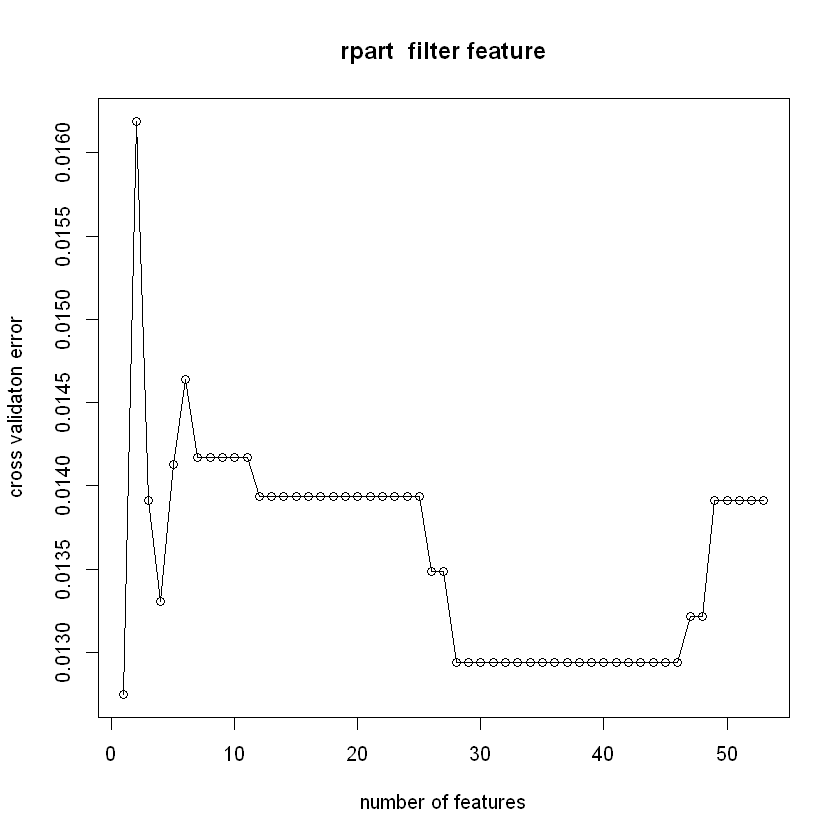

In [47]:
outputCorrelation('rpart', X, Y) # best 4  ; CV error= 0.0133  ; std dev= 0.0101

rpart Features:  1  ; CV error= 0.0127  ; std dev= 0.0098
rpart Features:  2  ; CV error= 0.0145  ; std dev= 0.0108
rpart Features:  3  ; CV error= 0.0145  ; std dev= 0.0108
rpart Features:  4  ; CV error= 0.017  ; std dev= 0.0111
rpart Features:  5  ; CV error= 0.0129  ; std dev= 0.0097
rpart Features:  6  ; CV error= 0.0129  ; std dev= 0.0097
rpart Features:  7  ; CV error= 0.0147  ; std dev= 0.0085
rpart Features:  8  ; CV error= 0.0138  ; std dev= 0.0123
rpart Features:  9  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  10  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  11  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  12  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  13  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  14  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  15  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  16  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  17  ; CV error= 0.0139  ; std dev= 0.0122
rpart F

[1]  3 33 32  9 18 37  5  8  6 52 19 12 17 50 16 46  7 29 20 13 34 53 21 22  2
[26] 15 10 45 14 30 39 42 24 48 35 49 31  4 51 47  1 28 27 25 43 26 23 38 44 36
[51] 11 40 41

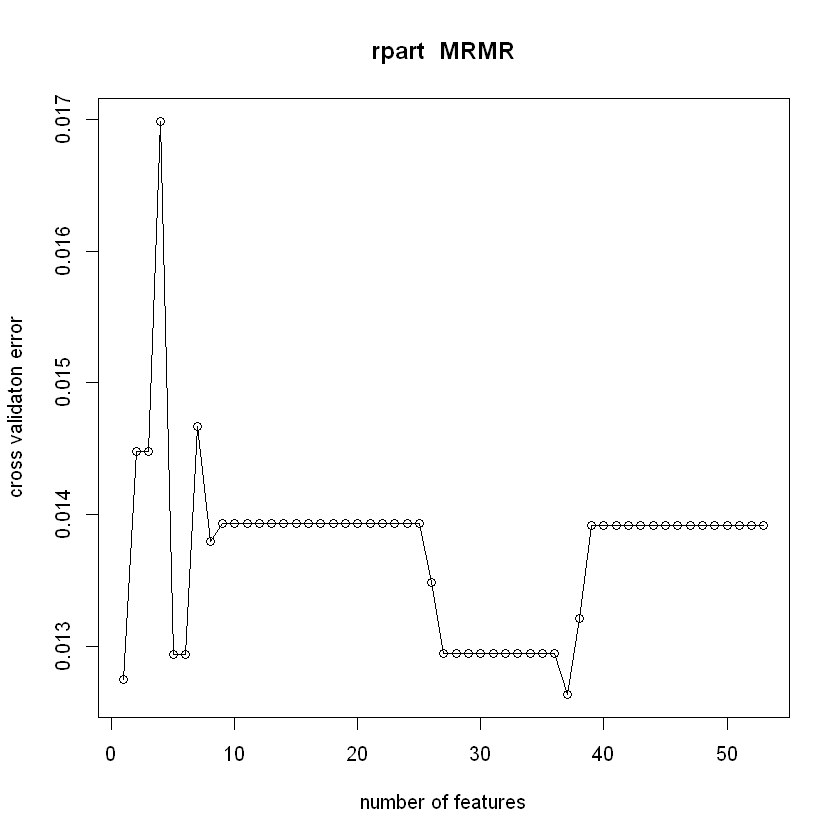

In [48]:
mrmr('rpart', X, Y) #5  ; CV error= 0.0129  ; std dev= 0.0097

rpart  Features:  1  ; CV error= 0.0282  ; std dev= 0.0156
rpart  Features:  2  ; CV error= 0.0179  ; std dev= 0.0148
rpart  Features:  3  ; CV error= 0.0179  ; std dev= 0.0148
rpart  Features:  4  ; CV error= 0.0216  ; std dev= 0.0135
rpart  Features:  5  ; CV error= 0.0208  ; std dev= 0.0125
rpart  Features:  6  ; CV error= 0.0208  ; std dev= 0.0125
rpart  Features:  7  ; CV error= 0.0208  ; std dev= 0.0125
rpart  Features:  8  ; CV error= 0.0209  ; std dev= 0.0124
rpart  Features:  9  ; CV error= 0.0209  ; std dev= 0.0124
rpart  Features:  10  ; CV error= 0.0209  ; std dev= 0.0124
rpart  Features:  11  ; CV error= 0.0209  ; std dev= 0.0124
rpart  Features:  12  ; CV error= 0.0209  ; std dev= 0.0124
rpart  Features:  13  ; CV error= 0.0209  ; std dev= 0.0124
rpart  Features:  14  ; CV error= 0.0187  ; std dev= 0.0119
rpart  Features:  15  ; CV error= 0.0187  ; std dev= 0.0119
rpart  Features:  16  ; CV error= 0.0187  ; std dev= 0.0119
rpart  Features:  17  ; CV error= 0.0187  ; std d

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53
-2065.8900,113.85787,24.586562,-263.05927,114.39034,-35.966998,98.251314,-22.2563486,8.991420,-33.5371991,...,-0.0361186178,-0.0134996699,-9.637035e-03,0.0158178409,0.010479243,0.0031713373,5.108912e-04,-1.800349e-15,9.852897e-15,4.226643e-15
-917.7324,-80.56677,56.802655,311.90552,-49.13922,79.873217,-212.211965,25.3229535,27.978980,-0.4423982,...,-0.0039664524,0.0791592561,-2.282335e-02,-0.0398591567,-0.021293703,0.0286470766,1.690550e-03,1.283989e-15,-1.439854e-14,-7.493149e-15
735.5653,164.30935,26.020367,-255.83505,121.88118,22.539234,108.322183,-3.6583613,25.798515,-35.5233323,...,0.0045835397,-0.0580196644,5.865202e-03,-0.0125646599,-0.002658810,-0.0040963616,3.305640e-03,-5.235930e-16,1.201783e-14,7.585068e-15
-967.1986,32.43131,29.024743,-356.47212,99.80338,180.994124,119.487181,181.4772171,-150.501842,69.9773916,...,-0.0101627556,0.0071614580,-3.748023e-02,-0.0896736628,-0.045738711,0.0030905821,-1.337442e-02,-2.601792e-15,2.751585e-14,2.265808e-14
3755.0246,646.20132,-4.414132,-287.38469,299.36149,-12.543487,-34.891756,-6.8897716,-6.894603,-19.3498569,...,-0.0060990404,-0.0449619854,-2.159463e-02,-0.0148031662,-0.010836986,0.0264627954,5.392760e-05,-5.127549e-15,1.893985e-15,1.954078e-14
3593.3691,-396.23283,-623.858069,-113.03379,49.45908,84.884211,45.014513,-12.0048528,28.845527,-43.2800847,...,0.0192001239,0.0159190477,-8.827009e-03,0.0557699450,-0.007157297,-0.0152493567,6.511404e-03,-1.433199e-14,7.091217e-15,7.883440e-15
-421.9633,547.43320,12.800868,428.32662,17.68625,18.335130,-127.213224,4.5789904,1.564307,-12.3107439,...,0.0081930929,0.0374832895,1.270482e-02,-0.0061500440,0.019783448,0.0109424068,-2.571335e-04,2.951965e-16,-1.487732e-14,1.499658e-15
-125.0050,497.46410,-354.835677,-278.47439,-24.62442,-89.219739,-102.538710,34.1781467,-241.090180,64.8879603,...,0.0273057340,-0.0173733275,-2.855771e-02,-0.0147581561,-0.010837674,-0.0075147045,3.196137e-03,-1.291993e-14,-4.573064e-15,2.720132e-14
-4394.0278,212.66731,10.000148,-235.39678,-87.98945,96.138218,9.911098,161.3974038,-82.918799,49.5532325,...,-0.0187958953,0.0217793466,-1.187100e-02,-0.0581329208,0.033768174,0.0037513011,7.361961e-03,-4.756318e-15,1.122680e-14,1.604358e-14
-3104.7676,-404.87518,72.281191,169.30152,-195.33960,-60.925170,45.907805,-2.9113422,35.994159,-31.7192467,...,0.0060958750,0.0866370437,-1.193311e-02,-0.0340776683,-0.047939500,0.0174911680,3.136707e-03,1.352073e-14,-6.307787e-15,-1.924243e-14


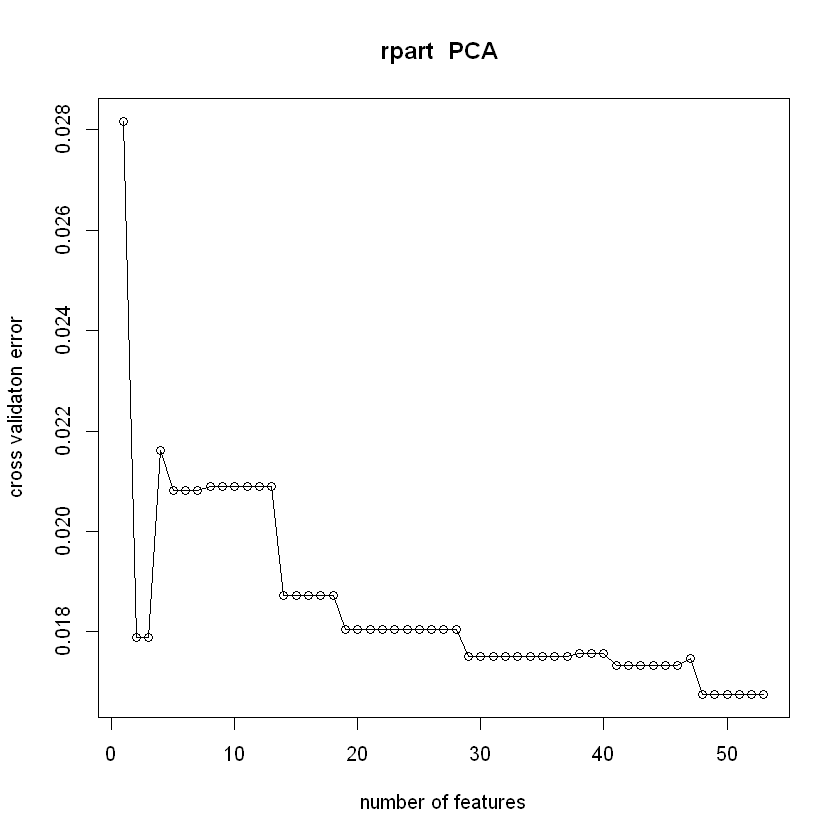

In [49]:
pca('rpart', X, Y)# Features:  3  ; CV error= 0.0179  ; std dev= 0.0148

In [50]:
forwardSelection('rpart', X, Y) #"Round  3  ; Selected feature:  45  ; CV error= 0.0118  ; std dev= 0.0091"

[1] "Round  1  ; Selected feature:  3  ; CV error= 0.0127  ; std dev= 0.0098"
[1] "Round  2  ; Selected feature:  14  ; CV error= 0.0119  ; std dev= 0.0093"
[1] "Round  3  ; Selected feature:  45  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  4  ; Selected feature:  1  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  5  ; Selected feature:  4  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  6  ; Selected feature:  7  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  7  ; Selected feature:  10  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  8  ; Selected feature:  11  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  9  ; Selected feature:  13  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  10  ; Selected feature:  15  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  11  ; Selected feature:  20  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  12  ; Selected feature:  21  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  13  ; Selected feature:  22  ; CV error= 

[1]  3 14 45  1  4  7 10 11 13 15 20 21 22 23 24 25 26 27 28 29 30 31 35 36 38
[26] 39 40 41 42 43 44 46 47 48 49 50 51 52 53  8 19 17 33  5  6 16 32 34 37 18
[51]  2 12  9

In [51]:
runEnsemble('rpart', X, Y)#0.0183  

[1] "Ensemble  rpart   CV error= 0.0183  ; std dev= 0.0098"


rpart Features:  1  ; CV error= 0.0127  ; std dev= 0.0098
rpart Features:  2  ; CV error= 0.0145  ; std dev= 0.0108
rpart Features:  3  ; CV error= 0.0145  ; std dev= 0.0108
rpart Features:  4  ; CV error= 0.017  ; std dev= 0.0111
rpart Features:  5  ; CV error= 0.0129  ; std dev= 0.0097
rpart Features:  6  ; CV error= 0.0129  ; std dev= 0.0097
rpart Features:  7  ; CV error= 0.0147  ; std dev= 0.0085
rpart Features:  8  ; CV error= 0.0138  ; std dev= 0.0123
rpart Features:  9  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  10  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  11  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  12  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  13  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  14  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  15  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  16  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  17  ; CV error= 0.0139  ; std dev= 0.0122
rpart F

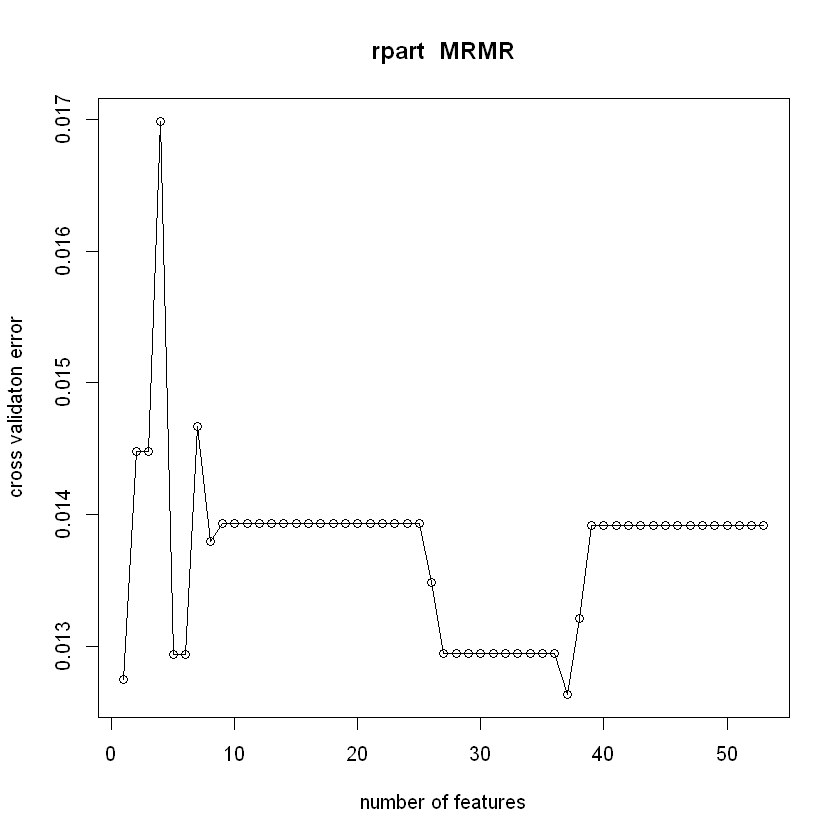

In [52]:
#the winner is mrmr
rpartIndexes <- mrmr('rpart', X, Y)
rpartIndexes <- rpartIndexes[1:5]

runEnsemble('rpart', X[,rpartIndexes], Y) #0.0158  

## SVM

In [53]:
X<- data[1:nrow(input),]
runModel('svm', X, Y) #0.0143

[1] "svm   CV error= 0.0143  ; std dev= 0.0064"


In [136]:
outputCorrelation('svm', X, Y) #svm  filter features:  16  ; CV error= 0.0137  ; std dev= 0.0095

In [ ]:
mrmr('svm', X, Y) #svm Features:  19  ; CV error= 0.0131  ; std dev= 0.0084

In [ ]:
pca('svm', X, Y) #

In [ ]:
forwardSelection('svm', X, Y) #"Round  12  ; Selected feature:  36  ; CV error= 0.0039  ; std dev= 0.0032"

In [ ]:
runEnsemble('svm', X, Y)# # 0.0148

In [55]:
#the winner is forward selection
svmIndexes <- c(3, 14,4 ,53, 40, 30, 39, 48, 51, 26, 15, 36)

runEnsemble('svm', X[, svmIndexes], Y) # 0.0039  

[1] "Ensemble  svm   CV error= 0.0039  ; std dev= 0.0045"


## LAZY


In [60]:
X<- numeric.df[1:nrow(input),] 
runModel('lazy', X, Y) #0.0403  

[1] "lazy   CV error= 0.0403  ; std dev= 0.0455"


lazy  filter features:  1  ; CV error= 0.0161  ; std dev= 0.0112
lazy  filter features:  2  ; CV error= 0.0171  ; std dev= 0.0183
lazy  filter features:  3  ; CV error= 0.0123  ; std dev= 0.0065
lazy  filter features:  4  ; CV error= 0.0524  ; std dev= 0.041
lazy  filter features:  5  ; CV error= 0.066  ; std dev= 0.0564
lazy  filter features:  6  ; CV error= 0.0515  ; std dev= 0.0534
lazy  filter features:  7  ; CV error= 0.0411  ; std dev= 0.0431
lazy  filter features:  8  ; CV error= 0.0424  ; std dev= 0.0488
lazy  filter features:  9  ; CV error= 0.0343  ; std dev= 0.0427
lazy  filter features:  10  ; CV error= 0.0262  ; std dev= 0.0294
lazy  filter features:  11  ; CV error= 0.0158  ; std dev= 0.0093
lazy  filter features:  12  ; CV error= 0.0285  ; std dev= 0.0282
lazy  filter features:  13  ; CV error= 0.0258  ; std dev= 0.0291
lazy  filter features:  14  ; CV error= 0.0199  ; std dev= 0.0223
lazy  filter features:  15  ; CV error= 0.0116  ; std dev= 0.009
lazy  filter features:

[1]  3  9 18 19  8 12  5  6 16 17  7 20 13 21  2 10 14 15 22 24  1 25 27 28  4
[26] 23 26 11

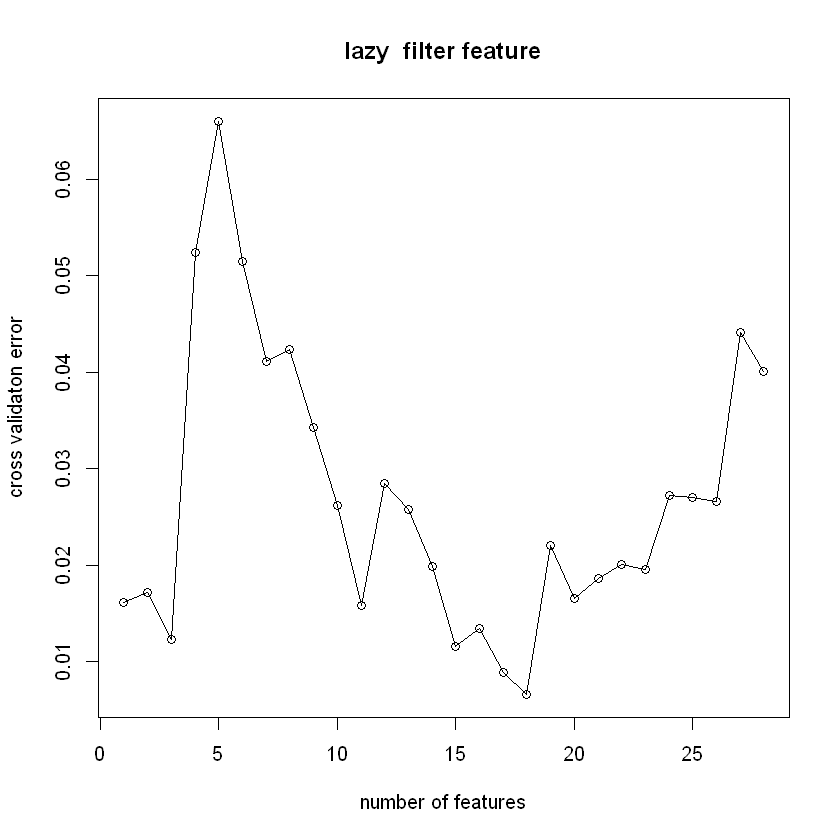

In [61]:
outputCorrelation('lazy', X, Y)#18  ; CV error= 0.0066  ; std dev= 0.0057

lazy Features:  1  ; CV error= 0.0161  ; std dev= 0.0112
lazy Features:  2  ; CV error= 0.0218  ; std dev= 0.0148
lazy Features:  3  ; CV error= 0.0448  ; std dev= 0.0536
lazy Features:  4  ; CV error= 0.1069  ; std dev= 0.083
lazy Features:  5  ; CV error= 0.0751  ; std dev= 0.065
lazy Features:  6  ; CV error= 0.0775  ; std dev= 0.0772
lazy Features:  7  ; CV error= 0.0991  ; std dev= 0.074
lazy Features:  8  ; CV error= 0.0866  ; std dev= 0.074
lazy Features:  9  ; CV error= 0.0836  ; std dev= 0.0546
lazy Features:  10  ; CV error= 0.0646  ; std dev= 0.049
lazy Features:  11  ; CV error= 0.065  ; std dev= 0.0562
lazy Features:  12  ; CV error= 0.0617  ; std dev= 0.052
lazy Features:  13  ; CV error= 0.0343  ; std dev= 0.0281
lazy Features:  14  ; CV error= 0.0364  ; std dev= 0.0462
lazy Features:  15  ; CV error= 0.0454  ; std dev= 0.0394
lazy Features:  16  ; CV error= 0.039  ; std dev= 0.0334
lazy Features:  17  ; CV error= 0.0337  ; std dev= 0.0349
lazy Features:  18  ; CV error=

[1]  3 15 18  9  5  8 22  6 17 19 12 16  7 20 13 10 21  2  4 24 14  1 28 27 26
[26] 23 25 11

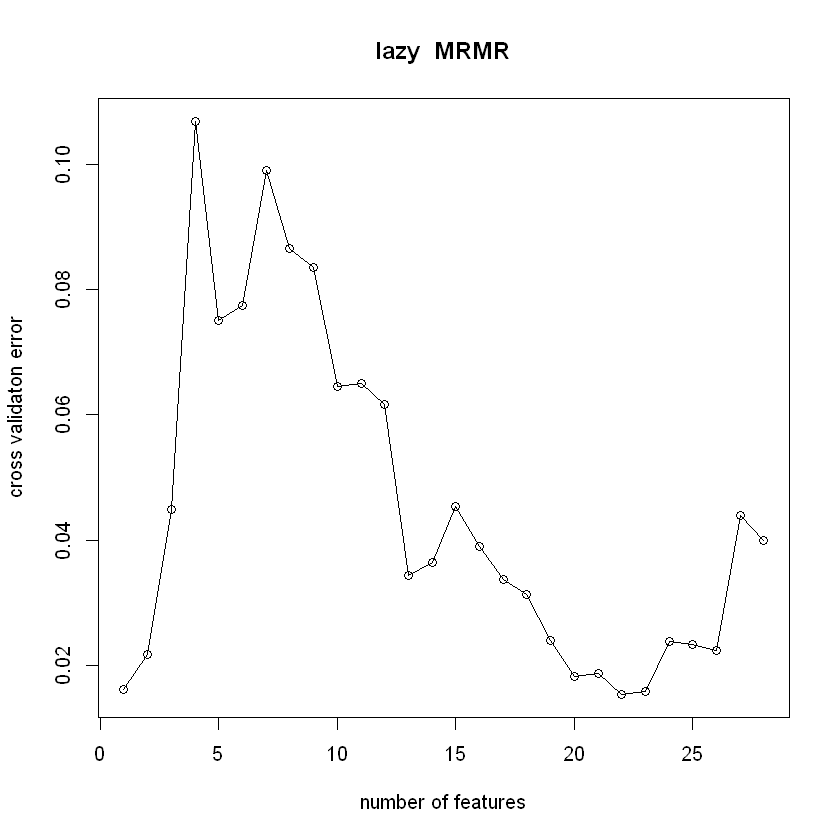

In [62]:
mrmr('lazy', X, Y)#22  ; CV error= 0.0153  ; std dev= 0.0096

lazy  Features:  1  ; CV error= 0.0345  ; std dev= 0.0216
lazy  Features:  2  ; CV error= 0.0181  ; std dev= 0.0175
lazy  Features:  3  ; CV error= 0.0229  ; std dev= 0.0188
lazy  Features:  4  ; CV error= 0.0805  ; std dev= 0.1176
lazy  Features:  5  ; CV error= 0.0935  ; std dev= 0.1555
lazy  Features:  6  ; CV error= 0.2507  ; std dev= 0.3708
lazy  Features:  7  ; CV error= 0.1969  ; std dev= 0.3504
lazy  Features:  8  ; CV error= 0.1019  ; std dev= 0.1975
lazy  Features:  9  ; CV error= 0.0442  ; std dev= 0.0722
lazy  Features:  10  ; CV error= 0.0564  ; std dev= 0.0617
lazy  Features:  11  ; CV error= 0.1744  ; std dev= 0.4101
lazy  Features:  12  ; CV error= 0.2716  ; std dev= 0.4128
lazy  Features:  13  ; CV error= 0.1661  ; std dev= 0.1818
lazy  Features:  14  ; CV error= 0.0902  ; std dev= 0.0781
lazy  Features:  15  ; CV error= 0.0991  ; std dev= 0.1064
lazy  Features:  16  ; CV error= 0.0531  ; std dev= 0.0591
lazy  Features:  17  ; CV error= 0.0912  ; std dev= 0.1178
lazy  

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28
-2065.8900,113.85792,24.586513,263.0594,114.39025,-35.967129,-98.251314,-22.2560031,8.990474,-33.5365523,...,0.26268057,-0.32928352,-0.085160242,-0.808687722,-0.58202540,-0.15388255,-0.06789207,-0.28058861,-0.147156777,0.091651860
-917.7324,-80.56675,56.802650,-311.9055,-49.13928,79.873186,212.212160,25.3229159,27.979274,-0.4423117,...,2.30582469,0.75705743,0.161850748,0.534085294,0.85509626,-0.09937444,-0.32991551,-0.06858620,-0.807748581,-0.044661437
735.5653,164.30915,26.020406,255.8353,121.88086,22.539030,-108.322870,-3.6573112,25.796962,-35.5229479,...,-0.86127232,0.18791607,-0.136872700,0.371886289,-0.71567372,-0.18235727,0.07821528,-0.39044196,-0.074871819,-0.059361191
-967.1986,32.43104,29.024820,356.4721,99.80322,180.994055,-119.487512,181.4764056,-150.502830,69.9779698,...,-0.56776510,-1.69592686,-0.383220813,0.170613523,-0.72926330,-0.46643076,-0.58519234,0.72619215,-0.004393291,0.029657255
3755.0246,646.20113,-4.414097,287.3848,299.36128,-12.543443,34.891324,-6.8893584,-6.894942,-19.3498927,...,0.42096196,-0.37434265,-0.173959806,0.042741958,-0.76939988,-0.04997115,-0.02258472,0.01591037,0.002187477,0.068953123
3593.3691,-396.23305,-623.857989,113.0340,49.45887,84.884165,-45.015105,-12.0040570,28.844119,-43.2803400,...,-1.77360956,0.85383511,-0.636470994,-1.251402299,-0.32454363,0.45562594,-0.25305965,0.16654138,0.051618656,0.003685003
-421.9633,547.43326,12.800807,-428.3266,17.68638,18.335204,127.213571,4.5786859,1.564227,-12.3106668,...,0.09683866,-0.67060324,0.012558059,0.113361018,-0.27794267,-0.50503013,0.33581921,-0.14752898,-0.003109245,-0.059801635
-125.0050,497.46385,-354.835634,278.4744,-24.62461,-89.219890,102.538322,34.1770727,-241.090290,64.8888847,...,0.34506098,0.54719755,-0.855262469,0.457111901,-0.11863785,-0.19985576,-0.32178093,-0.21113661,-0.006865037,-0.052631585
-4394.0278,212.66759,10.000079,235.3965,-87.98918,96.138450,-9.910449,161.3964922,-82.917976,49.5539440,...,0.20057404,-1.94790289,-1.175946087,-0.159436643,1.21635374,-0.42129946,-0.26656346,-0.23538997,-0.052927745,-0.851166181
-3104.7676,-404.87516,72.281198,-169.3016,-195.33952,-60.925290,-45.907632,-2.9117863,35.995338,-31.7200229,...,0.47553911,-0.22807586,-1.421993519,0.727462660,0.13871272,-0.43802030,-0.03545600,0.03817294,0.070149705,-0.780883386


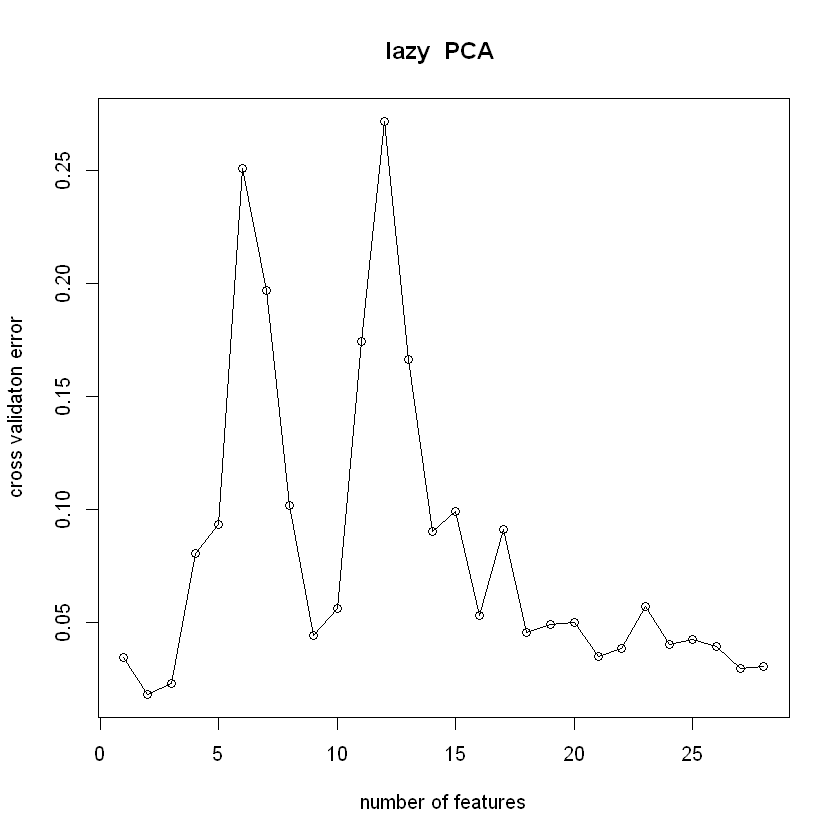

In [63]:
pca('lazy', X, Y)#Features:  2  ; CV error= 0.0181  ; std dev= 0.0175

In [64]:
forwardSelection('lazy', X, Y) #2  ; Selected feature:  13  ; CV error= 0.0102  ; std dev= 0.0081"

[1] "Round  1  ; Selected feature:  3  ; CV error= 0.0161  ; std dev= 0.0112"
[1] "Round  2  ; Selected feature:  13  ; CV error= 0.0102  ; std dev= 0.0081"
[1] "Round  3  ; Selected feature:  15  ; CV error= 0.0174  ; std dev= 0.0158"
[1] "Round  4  ; Selected feature:  24  ; CV error= 0.0259  ; std dev= 0.0155"
[1] "Round  5  ; Selected feature:  28  ; CV error= 0.0297  ; std dev= 0.026"
[1] "Round  6  ; Selected feature:  27  ; CV error= 0.0147  ; std dev= 0.0135"
[1] "Round  7  ; Selected feature:  11  ; CV error= 0.0146  ; std dev= 0.0131"
[1] "Round  8  ; Selected feature:  25  ; CV error= 0.0188  ; std dev= 0.0137"
[1] "Round  9  ; Selected feature:  17  ; CV error= 0.0236  ; std dev= 0.0112"
[1] "Round  10  ; Selected feature:  12  ; CV error= 0.0189  ; std dev= 0.0159"
[1] "Round  11  ; Selected feature:  6  ; CV error= 0.0198  ; std dev= 0.0142"
[1] "Round  12  ; Selected feature:  14  ; CV error= 0.0199  ; std dev= 0.0152"
[1] "Round  13  ; Selected feature:  10  ; CV error=

[1]  3 13 15 24 28 27 11 25 17 12  6 14 10 16 18 26 23  4  1 21 22  7  5  9 20
[26] 19  2  8

In [65]:
runEnsemble('lazy', X, Y)

[1] "Ensemble  lazy   CV error= 0.1037  ; std dev= 0.0606"


lazy  filter features:  1  ; CV error= 0.0161  ; std dev= 0.0112
lazy  filter features:  2  ; CV error= 0.0171  ; std dev= 0.0183
lazy  filter features:  3  ; CV error= 0.0123  ; std dev= 0.0065
lazy  filter features:  4  ; CV error= 0.0524  ; std dev= 0.041
lazy  filter features:  5  ; CV error= 0.066  ; std dev= 0.0564
lazy  filter features:  6  ; CV error= 0.0515  ; std dev= 0.0534
lazy  filter features:  7  ; CV error= 0.0411  ; std dev= 0.0431
lazy  filter features:  8  ; CV error= 0.0424  ; std dev= 0.0488
lazy  filter features:  9  ; CV error= 0.0343  ; std dev= 0.0427
lazy  filter features:  10  ; CV error= 0.0262  ; std dev= 0.0294
lazy  filter features:  11  ; CV error= 0.0158  ; std dev= 0.0093
lazy  filter features:  12  ; CV error= 0.0285  ; std dev= 0.0282
lazy  filter features:  13  ; CV error= 0.0258  ; std dev= 0.0291
lazy  filter features:  14  ; CV error= 0.0199  ; std dev= 0.0223
lazy  filter features:  15  ; CV error= 0.0116  ; std dev= 0.009
lazy  filter features:

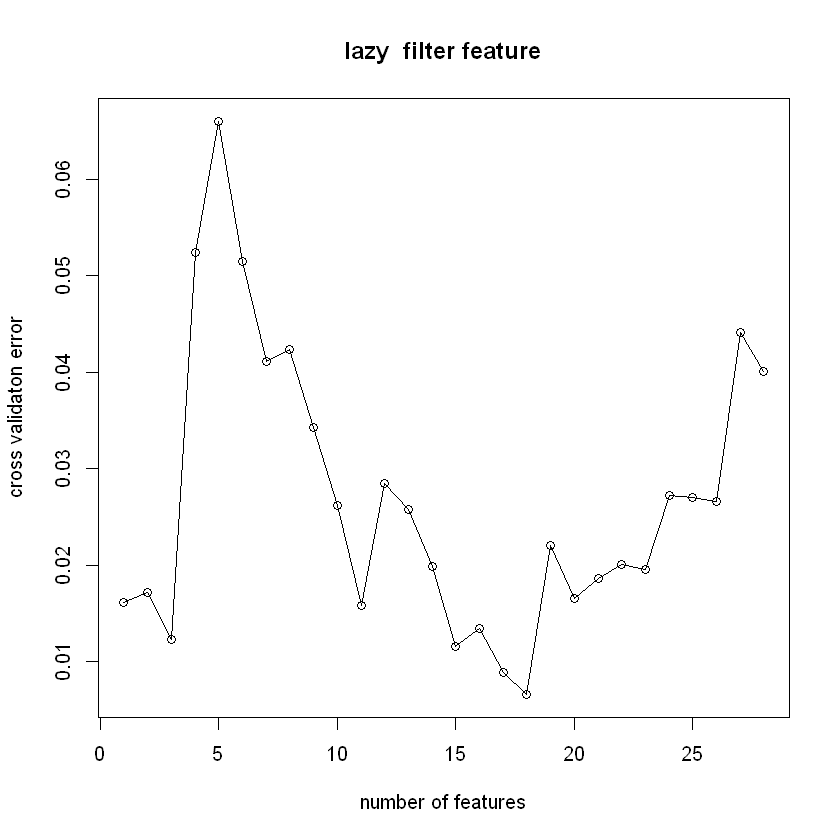

In [66]:
#the winner is
lazyIndexes<- outputCorrelation('lazy', X, Y)

lazyIndexes <- lazyIndexes[1:18]


In [70]:
runEnsemble('lazy', X[, lazyIndexes], Y)#CV error= 0.0508    

[1] "Ensemble  lazy   CV error= 0.0508  ; std dev= 0.0687"


## TREE

In [68]:
X<- data[1:nrow(input),]
runModel('tree', X, Y)

[1] "tree   CV error= 0.0139  ; std dev= 0.011"


tree  filter features:  1  ; CV error= 0.0125  ; std dev= 0.0093
tree  filter features:  2  ; CV error= 0.0162  ; std dev= 0.0101
tree  filter features:  3  ; CV error= 0.0139  ; std dev= 0.0101
tree  filter features:  4  ; CV error= 0.0133  ; std dev= 0.0101
tree  filter features:  5  ; CV error= 0.0141  ; std dev= 0.0117
tree  filter features:  6  ; CV error= 0.0146  ; std dev= 0.0111
tree  filter features:  7  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  8  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  9  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  10  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  11  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  12  ; CV error= 0.0139  ; std dev= 0.0122
tree  filter features:  13  ; CV error= 0.0139  ; std dev= 0.0122
tree  filter features:  14  ; CV error= 0.0139  ; std dev= 0.0122
tree  filter features:  15  ; CV error= 0.0139  ; std dev= 0.0122
tree  filter featur

[1]  3  9 18 19  8 12  5  6 16 17  7 33 20 13 21 32 37  2 34 52 10 50 14 29 46
[26] 53 15 22 39 45 24 35 30 48 42 49 47 51  1 31 25 27 28  4 43 23 36 26 44 38
[51] 11 41 40

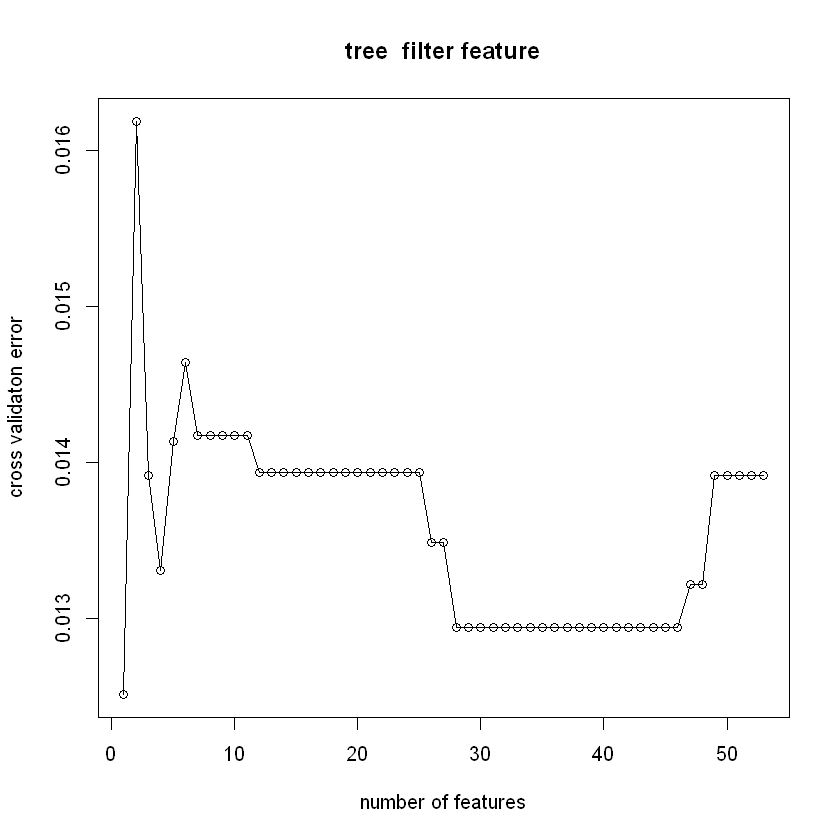

In [69]:
outputCorrelation('tree', X, Y) #28  ; CV error= 0.0129  ; std dev= 0.0115

tree Features:  1  ; CV error= 0.0125  ; std dev= 0.0093
tree Features:  2  ; CV error= 0.0137  ; std dev= 0.0107
tree Features:  3  ; CV error= 0.0137  ; std dev= 0.0107
tree Features:  4  ; CV error= 0.017  ; std dev= 0.0111
tree Features:  5  ; CV error= 0.0129  ; std dev= 0.0097
tree Features:  6  ; CV error= 0.0129  ; std dev= 0.0097
tree Features:  7  ; CV error= 0.0147  ; std dev= 0.0085
tree Features:  8  ; CV error= 0.0138  ; std dev= 0.0123
tree Features:  9  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  10  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  11  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  12  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  13  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  14  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  15  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  16  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  17  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  18  ; CV

[1]  3 33 32  9 18 37  5  8  6 52 19 12 17 50 16 46  7 29 20 13 34 53 21 22  2
[26] 15 10 45 14 30 39 42 24 48 35 49 31  4 51 47  1 28 27 25 43 26 23 38 44 36
[51] 11 40 41

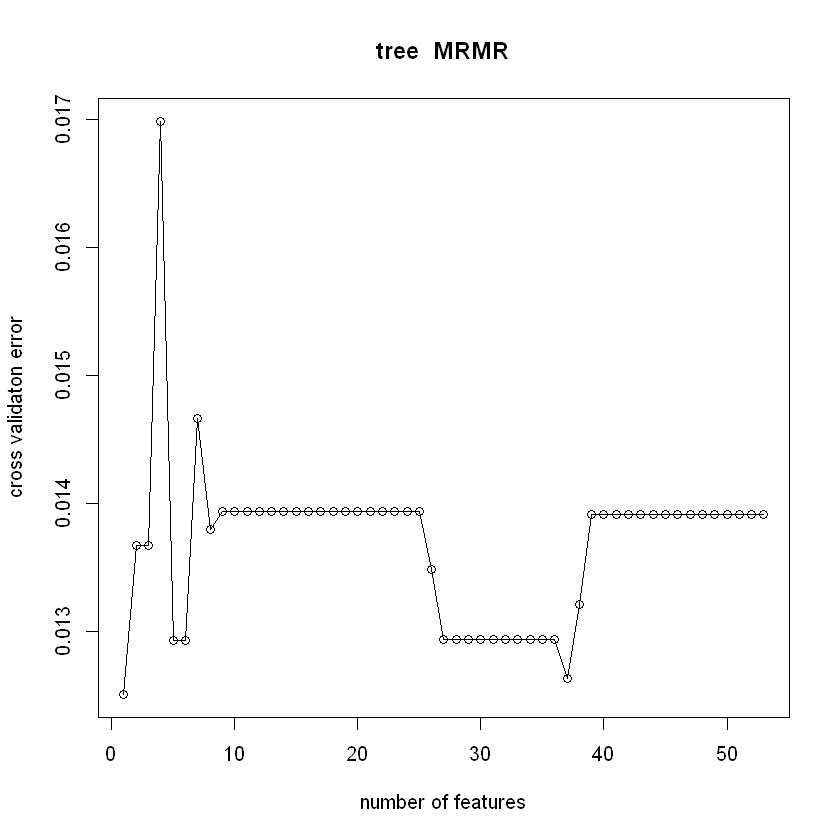

In [71]:
mrmr('tree', X, Y)#4  ; CV error= 0.017  ; std dev= 0.0111

tree  Features:  1  ; CV error= 0.0282  ; std dev= 0.0156
tree  Features:  2  ; CV error= 0.0178  ; std dev= 0.0151
tree  Features:  3  ; CV error= 0.0178  ; std dev= 0.0151
tree  Features:  4  ; CV error= 0.0204  ; std dev= 0.0132
tree  Features:  5  ; CV error= 0.0196  ; std dev= 0.0123
tree  Features:  6  ; CV error= 0.0196  ; std dev= 0.0123
tree  Features:  7  ; CV error= 0.0196  ; std dev= 0.0123
tree  Features:  8  ; CV error= 0.0197  ; std dev= 0.0122
tree  Features:  9  ; CV error= 0.0197  ; std dev= 0.0122
tree  Features:  10  ; CV error= 0.0197  ; std dev= 0.0122
tree  Features:  11  ; CV error= 0.0197  ; std dev= 0.0122
tree  Features:  12  ; CV error= 0.0197  ; std dev= 0.0122
tree  Features:  13  ; CV error= 0.0197  ; std dev= 0.0122
tree  Features:  14  ; CV error= 0.0171  ; std dev= 0.0118
tree  Features:  15  ; CV error= 0.0171  ; std dev= 0.0118
tree  Features:  16  ; CV error= 0.0171  ; std dev= 0.0118
tree  Features:  17  ; CV error= 0.0171  ; std dev= 0.0118
tree  

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53
-2065.8900,113.85787,24.586562,-263.05927,114.39034,-35.966998,98.251314,-22.2563486,8.991420,-33.5371991,...,-0.0361186178,-0.0134996699,-9.637035e-03,0.0158178409,0.010479243,0.0031713373,5.108912e-04,-1.800349e-15,9.852897e-15,4.226643e-15
-917.7324,-80.56677,56.802655,311.90552,-49.13922,79.873217,-212.211965,25.3229535,27.978980,-0.4423982,...,-0.0039664524,0.0791592561,-2.282335e-02,-0.0398591567,-0.021293703,0.0286470766,1.690550e-03,1.283989e-15,-1.439854e-14,-7.493149e-15
735.5653,164.30935,26.020367,-255.83505,121.88118,22.539234,108.322183,-3.6583613,25.798515,-35.5233323,...,0.0045835397,-0.0580196644,5.865202e-03,-0.0125646599,-0.002658810,-0.0040963616,3.305640e-03,-5.235930e-16,1.201783e-14,7.585068e-15
-967.1986,32.43131,29.024743,-356.47212,99.80338,180.994124,119.487181,181.4772171,-150.501842,69.9773916,...,-0.0101627556,0.0071614580,-3.748023e-02,-0.0896736628,-0.045738711,0.0030905821,-1.337442e-02,-2.601792e-15,2.751585e-14,2.265808e-14
3755.0246,646.20132,-4.414132,-287.38469,299.36149,-12.543487,-34.891756,-6.8897716,-6.894603,-19.3498569,...,-0.0060990404,-0.0449619854,-2.159463e-02,-0.0148031662,-0.010836986,0.0264627954,5.392760e-05,-5.127549e-15,1.893985e-15,1.954078e-14
3593.3691,-396.23283,-623.858069,-113.03379,49.45908,84.884211,45.014513,-12.0048528,28.845527,-43.2800847,...,0.0192001239,0.0159190477,-8.827009e-03,0.0557699450,-0.007157297,-0.0152493567,6.511404e-03,-1.433199e-14,7.091217e-15,7.883440e-15
-421.9633,547.43320,12.800868,428.32662,17.68625,18.335130,-127.213224,4.5789904,1.564307,-12.3107439,...,0.0081930929,0.0374832895,1.270482e-02,-0.0061500440,0.019783448,0.0109424068,-2.571335e-04,2.951965e-16,-1.487732e-14,1.499658e-15
-125.0050,497.46410,-354.835677,-278.47439,-24.62442,-89.219739,-102.538710,34.1781467,-241.090180,64.8879603,...,0.0273057340,-0.0173733275,-2.855771e-02,-0.0147581561,-0.010837674,-0.0075147045,3.196137e-03,-1.291993e-14,-4.573064e-15,2.720132e-14
-4394.0278,212.66731,10.000148,-235.39678,-87.98945,96.138218,9.911098,161.3974038,-82.918799,49.5532325,...,-0.0187958953,0.0217793466,-1.187100e-02,-0.0581329208,0.033768174,0.0037513011,7.361961e-03,-4.756318e-15,1.122680e-14,1.604358e-14
-3104.7676,-404.87518,72.281191,169.30152,-195.33960,-60.925170,45.907805,-2.9113422,35.994159,-31.7192467,...,0.0060958750,0.0866370437,-1.193311e-02,-0.0340776683,-0.047939500,0.0174911680,3.136707e-03,1.352073e-14,-6.307787e-15,-1.924243e-14


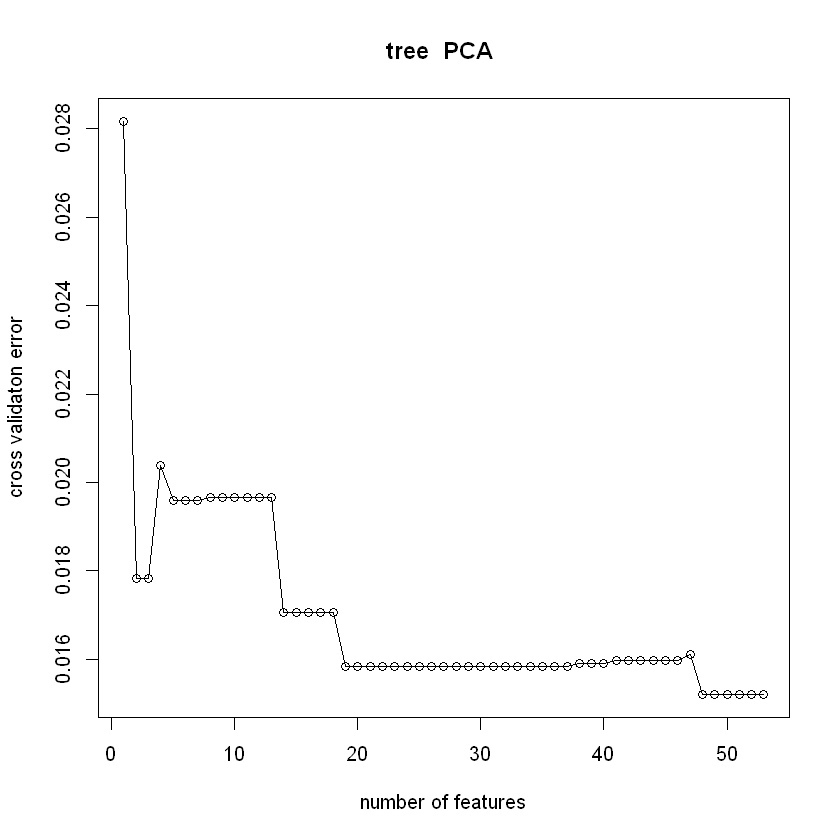

In [72]:
pca('tree', X, Y)#48  ; CV error= 0.0152  ; std dev= 0.013

In [73]:
forwardSelection('tree', X, Y) #44  ; Selected feature:  17  ; CV error= 0.0097  ; std dev= 0.009"

[1] "Round  1  ; Selected feature:  3  ; CV error= 0.0125  ; std dev= 0.0093"
[1] "Round  2  ; Selected feature:  14  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  3  ; Selected feature:  1  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  4  ; Selected feature:  4  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  5  ; Selected feature:  7  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  6  ; Selected feature:  10  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  7  ; Selected feature:  11  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  8  ; Selected feature:  13  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  9  ; Selected feature:  15  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  10  ; Selected feature:  20  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  11  ; Selected feature:  21  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  12  ; Selected feature:  22  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  13  ; Selected feature:  23  ; CV error= 

[1]  3 14  1  4  7 10 11 13 15 20 21 22 23 24 25 26 27 28 29 30 31 35 36 38 39
[26] 40 41 42 43 44 46 47 48 49 50 51 52 53 45  6 34 18  8 17  5 16 32 37 33  2
[51] 19 12  9

In [75]:
runEnsemble('tree', X, Y)

[1] "Ensemble  tree   CV error= 0.0156  ; std dev= 0.0102"


In [76]:
treeIndexes <-forwardSelection('tree', X, Y)
treeIndexes <- treeIndexes[1:44]



[1] "Round  1  ; Selected feature:  3  ; CV error= 0.0125  ; std dev= 0.0093"
[1] "Round  2  ; Selected feature:  14  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  3  ; Selected feature:  1  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  4  ; Selected feature:  4  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  5  ; Selected feature:  7  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  6  ; Selected feature:  10  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  7  ; Selected feature:  11  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  8  ; Selected feature:  13  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  9  ; Selected feature:  15  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  10  ; Selected feature:  20  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  11  ; Selected feature:  21  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  12  ; Selected feature:  22  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  13  ; Selected feature:  23  ; CV error= 

In [79]:
runEnsemble('tree', X[, treeIndexes], Y)

[1] "Ensemble  tree   CV error= 0.0145  ; std dev= 0.0103"


## LM

In [80]:
X<- data[1:nrow(input),]
runModel('lm', X, Y)

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "lm   CV error= 0.0099  ; std dev= 0.0048"


Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, rank

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be mis

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be mis

lm  filter features:  1  ; CV error= 0.0103  ; std dev= 0.0083
lm  filter features:  2  ; CV error= 0.0085  ; std dev= 0.0071
lm  filter features:  3  ; CV error= 0.0093  ; std dev= 0.0065
lm  filter features:  4  ; CV error= 0.0089  ; std dev= 0.0059
lm  filter features:  5  ; CV error= 0.0092  ; std dev= 0.0076
lm  filter features:  6  ; CV error= 0.0087  ; std dev= 0.0082
lm  filter features:  7  ; CV error= 0.0083  ; std dev= 0.0073
lm  filter features:  8  ; CV error= 0.0083  ; std dev= 0.0078
lm  filter features:  9  ; CV error= 0.0084  ; std dev= 0.008
lm  filter features:  10  ; CV error= 0.0106  ; std dev= 0.0075
lm  filter features:  11  ; CV error= 0.0105  ; std dev= 0.0075
lm  filter features:  12  ; CV error= 0.0107  ; std dev= 0.0063
lm  filter features:  13  ; CV error= 0.0109  ; std dev= 0.0059
lm  filter features:  14  ; CV error= 0.0106  ; std dev= 0.0061
lm  filter features:  15  ; CV error= 0.0106  ; std dev= 0.006
lm  filter features:  16  ; CV error= 0.0103  ; std

[1]  3  9 18 19  8 12  5  6 16 17  7 33 20 13 21 32 37  2 34 52 10 50 14 29 46
[26] 53 15 22 39 45 24 35 30 48 42 49 47 51  1 31 25 27 28  4 43 23 36 26 44 38
[51] 11 41 40

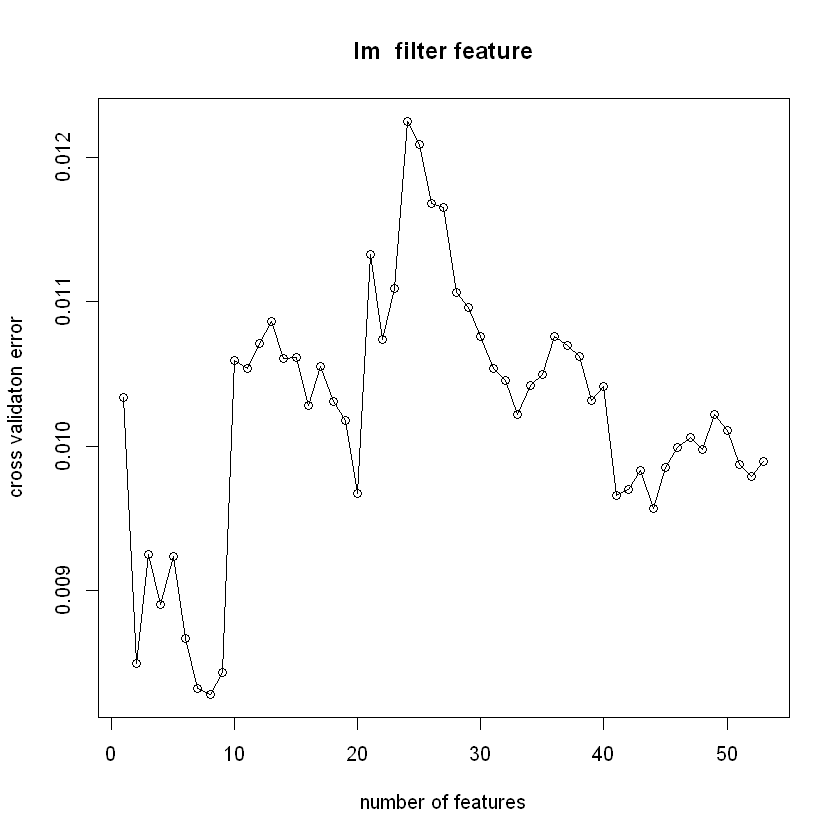

In [81]:
outputCorrelation('lm', X, Y) # 8  ; CV error= 0.0083

Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, rank

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be mis

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts[, ranking[1:nb_features], drop = F]):
"prediction from a rank-deficient fit may be mis

lm Features:  1  ; CV error= 0.0103  ; std dev= 0.0083
lm Features:  2  ; CV error= 0.0126  ; std dev= 0.007
lm Features:  3  ; CV error= 0.0127  ; std dev= 0.0064
lm Features:  4  ; CV error= 0.0107  ; std dev= 0.0064
lm Features:  5  ; CV error= 0.0093  ; std dev= 0.0051
lm Features:  6  ; CV error= 0.0094  ; std dev= 0.0045
lm Features:  7  ; CV error= 0.0092  ; std dev= 0.0077
lm Features:  8  ; CV error= 0.0095  ; std dev= 0.008
lm Features:  9  ; CV error= 0.0097  ; std dev= 0.0078
lm Features:  10  ; CV error= 0.0095  ; std dev= 0.008
lm Features:  11  ; CV error= 0.0097  ; std dev= 0.0076
lm Features:  12  ; CV error= 0.0094  ; std dev= 0.0079
lm Features:  13  ; CV error= 0.0104  ; std dev= 0.0066
lm Features:  14  ; CV error= 0.0098  ; std dev= 0.0065
lm Features:  15  ; CV error= 0.01  ; std dev= 0.0067
lm Features:  16  ; CV error= 0.0101  ; std dev= 0.0068
lm Features:  17  ; CV error= 0.0099  ; std dev= 0.0068
lm Features:  18  ; CV error= 0.0106  ; std dev= 0.006
lm Feat

[1]  3 33 32  9 18 37  5  8  6 52 19 12 17 50 16 46  7 29 20 13 34 53 21 22  2
[26] 15 10 45 14 30 39 42 24 48 35 49 31  4 51 47  1 28 27 25 43 26 23 38 44 36
[51] 11 40 41

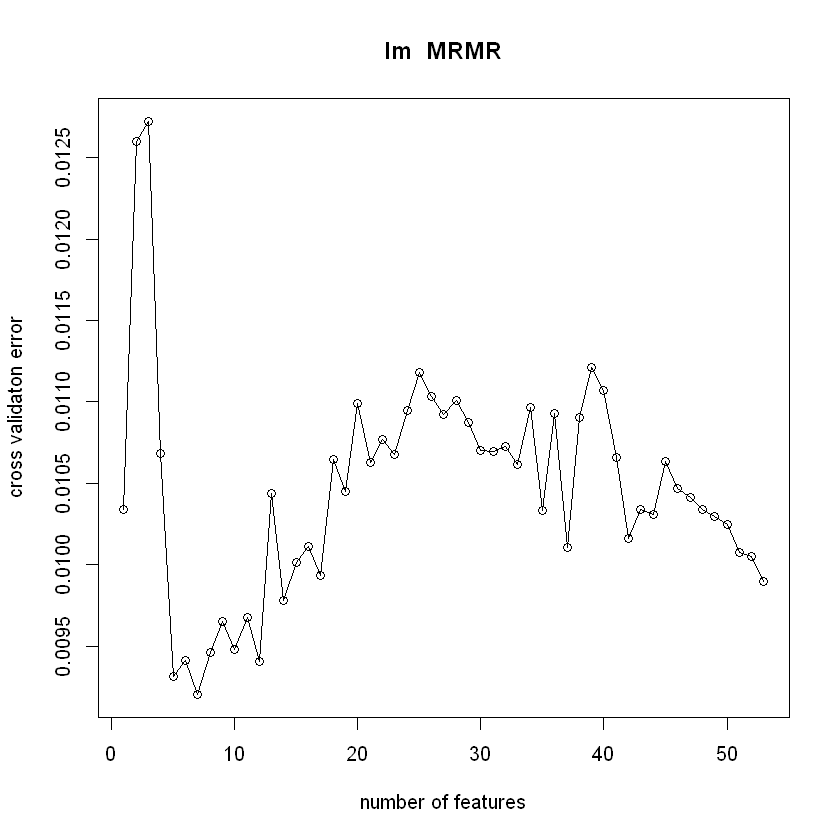

In [82]:
mrmr('lm', X, Y)#7  ; CV error= 0.0092  ; std dev= 0.0077

lm  Features:  1  ; CV error= 0.0273  ; std dev= 0.015
lm  Features:  2  ; CV error= 0.0148  ; std dev= 0.0144
lm  Features:  3  ; CV error= 0.0152  ; std dev= 0.0145
lm  Features:  4  ; CV error= 0.0154  ; std dev= 0.0146
lm  Features:  5  ; CV error= 0.0139  ; std dev= 0.0107
lm  Features:  6  ; CV error= 0.0143  ; std dev= 0.0105
lm  Features:  7  ; CV error= 0.0135  ; std dev= 0.0098
lm  Features:  8  ; CV error= 0.0128  ; std dev= 0.0097
lm  Features:  9  ; CV error= 0.0131  ; std dev= 0.0102
lm  Features:  10  ; CV error= 0.0131  ; std dev= 0.0102
lm  Features:  11  ; CV error= 0.0132  ; std dev= 0.0101
lm  Features:  12  ; CV error= 0.0127  ; std dev= 0.0105
lm  Features:  13  ; CV error= 0.0125  ; std dev= 0.0094
lm  Features:  14  ; CV error= 0.0089  ; std dev= 0.0074
lm  Features:  15  ; CV error= 0.009  ; std dev= 0.0074
lm  Features:  16  ; CV error= 0.0091  ; std dev= 0.0077
lm  Features:  17  ; CV error= 0.0091  ; std dev= 0.0079
lm  Features:  18  ; CV error= 0.0085  ; s

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53
-2065.8900,113.85787,24.586562,-263.05927,114.39034,-35.966998,98.251314,-22.2563486,8.991420,-33.5371991,...,-0.0361186178,-0.0134996699,-9.637035e-03,0.0158178409,0.010479243,0.0031713373,5.108912e-04,-1.800349e-15,9.852897e-15,4.226643e-15
-917.7324,-80.56677,56.802655,311.90552,-49.13922,79.873217,-212.211965,25.3229535,27.978980,-0.4423982,...,-0.0039664524,0.0791592561,-2.282335e-02,-0.0398591567,-0.021293703,0.0286470766,1.690550e-03,1.283989e-15,-1.439854e-14,-7.493149e-15
735.5653,164.30935,26.020367,-255.83505,121.88118,22.539234,108.322183,-3.6583613,25.798515,-35.5233323,...,0.0045835397,-0.0580196644,5.865202e-03,-0.0125646599,-0.002658810,-0.0040963616,3.305640e-03,-5.235930e-16,1.201783e-14,7.585068e-15
-967.1986,32.43131,29.024743,-356.47212,99.80338,180.994124,119.487181,181.4772171,-150.501842,69.9773916,...,-0.0101627556,0.0071614580,-3.748023e-02,-0.0896736628,-0.045738711,0.0030905821,-1.337442e-02,-2.601792e-15,2.751585e-14,2.265808e-14
3755.0246,646.20132,-4.414132,-287.38469,299.36149,-12.543487,-34.891756,-6.8897716,-6.894603,-19.3498569,...,-0.0060990404,-0.0449619854,-2.159463e-02,-0.0148031662,-0.010836986,0.0264627954,5.392760e-05,-5.127549e-15,1.893985e-15,1.954078e-14
3593.3691,-396.23283,-623.858069,-113.03379,49.45908,84.884211,45.014513,-12.0048528,28.845527,-43.2800847,...,0.0192001239,0.0159190477,-8.827009e-03,0.0557699450,-0.007157297,-0.0152493567,6.511404e-03,-1.433199e-14,7.091217e-15,7.883440e-15
-421.9633,547.43320,12.800868,428.32662,17.68625,18.335130,-127.213224,4.5789904,1.564307,-12.3107439,...,0.0081930929,0.0374832895,1.270482e-02,-0.0061500440,0.019783448,0.0109424068,-2.571335e-04,2.951965e-16,-1.487732e-14,1.499658e-15
-125.0050,497.46410,-354.835677,-278.47439,-24.62442,-89.219739,-102.538710,34.1781467,-241.090180,64.8879603,...,0.0273057340,-0.0173733275,-2.855771e-02,-0.0147581561,-0.010837674,-0.0075147045,3.196137e-03,-1.291993e-14,-4.573064e-15,2.720132e-14
-4394.0278,212.66731,10.000148,-235.39678,-87.98945,96.138218,9.911098,161.3974038,-82.918799,49.5532325,...,-0.0187958953,0.0217793466,-1.187100e-02,-0.0581329208,0.033768174,0.0037513011,7.361961e-03,-4.756318e-15,1.122680e-14,1.604358e-14
-3104.7676,-404.87518,72.281191,169.30152,-195.33960,-60.925170,45.907805,-2.9113422,35.994159,-31.7192467,...,0.0060958750,0.0866370437,-1.193311e-02,-0.0340776683,-0.047939500,0.0174911680,3.136707e-03,1.352073e-14,-6.307787e-15,-1.924243e-14


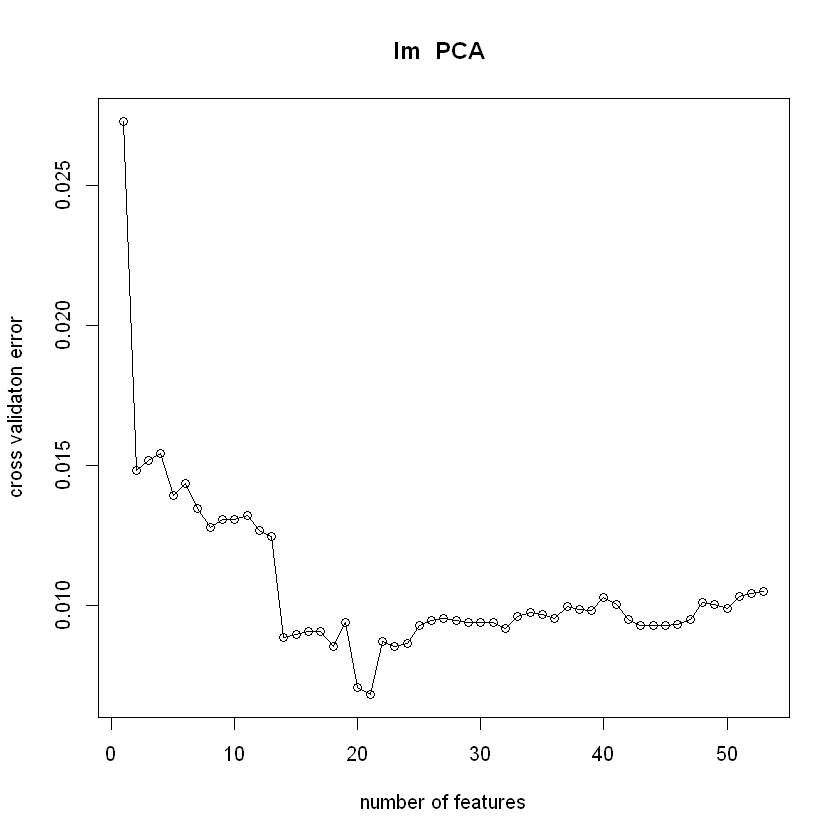

In [83]:
pca('lm', X, Y) #Features:  21  ; CV error= 0.0068  ; std dev= 0.0067

In [84]:
forwardSelection('lm', X, Y)

[1] "Round  1  ; Selected feature:  3  ; CV error= 0.0103  ; std dev= 0.0083"
[1] "Round  2  ; Selected feature:  9  ; CV error= 0.0085  ; std dev= 0.0071"
[1] "Round  3  ; Selected feature:  5  ; CV error= 0.0069  ; std dev= 0.0066"
[1] "Round  4  ; Selected feature:  47  ; CV error= 0.0057  ; std dev= 0.0052"
[1] "Round  5  ; Selected feature:  20  ; CV error= 0.0054  ; std dev= 0.0049"
[1] "Round  6  ; Selected feature:  19  ; CV error= 0.0049  ; std dev= 0.0037"
[1] "Round  7  ; Selected feature:  23  ; CV error= 0.0042  ; std dev= 0.0038"
[1] "Round  8  ; Selected feature:  42  ; CV error= 0.0037  ; std dev= 0.0041"
[1] "Round  9  ; Selected feature:  36  ; CV error= 0.0034  ; std dev= 0.0038"
[1] "Round  10  ; Selected feature:  31  ; CV error= 0.0032  ; std dev= 0.0039"
[1] "Round  11  ; Selected feature:  30  ; CV error= 0.0031  ; std dev= 0.0041"
[1] "Round  12  ; Selected feature:  21  ; CV error= 0.003  ; std dev= 0.0041"
[1] "Round  13  ; Selected feature:  41  ; CV error= 

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  30  ; Selected feature:  11  ; CV error= 0.0026  ; std dev= 0.0035"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  31  ; Selected feature:  38  ; CV error= 0.0026  ; std dev= 0.0035"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  32  ; Selected feature:  43  ; CV error= 0.0026  ; std dev= 0.0035"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  33  ; Selected feature:  51  ; CV error= 0.0028  ; std dev= 0.0033"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  34  ; Selected feature:  15  ; CV error= 0.0028  ; std dev= 0.0028"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  35  ; Selected feature:  45  ; CV error= 0.0028  ; std dev= 0.0028"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  36  ; Selected feature:  52  ; CV error= 0.0025  ; std dev= 0.0021"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  37  ; Selected feature:  53  ; CV error= 0.0023  ; std dev= 0.0026"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  38  ; Selected feature:  17  ; CV error= 0.0022  ; std dev= 0.001"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  39  ; Selected feature:  1  ; CV error= 0.0021  ; std dev= 0.0015"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  40  ; Selected feature:  13  ; CV error= 0.0021  ; std dev= 0.0016"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  41  ; Selected feature:  18  ; CV error= 0.0023  ; std dev= 0.0022"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  42  ; Selected feature:  37  ; CV error= 0.0026  ; std dev= 0.0023"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  43  ; Selected feature:  34  ; CV error= 0.0026  ; std dev= 0.0023"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  44  ; Selected feature:  49  ; CV error= 0.0032  ; std dev= 0.0026"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  45  ; Selected feature:  16  ; CV error= 0.0037  ; std dev= 0.0028"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  46  ; Selected feature:  33  ; CV error= 0.0043  ; std dev= 0.0033"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  47  ; Selected feature:  2  ; CV error= 0.0045  ; std dev= 0.0034"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  48  ; Selected feature:  6  ; CV error= 0.0056  ; std dev= 0.0036"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  49  ; Selected feature:  8  ; CV error= 0.0062  ; std dev= 0.0041"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  50  ; Selected feature:  29  ; CV error= 0.0075  ; std dev= 0.0043"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  51  ; Selected feature:  32  ; CV error= 0.0075  ; std dev= 0.0043"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  52  ; Selected feature:  4  ; CV error= 0.0086  ; std dev= 0.0041"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  53  ; Selected feature:  10  ; CV error= 0.0099  ; std dev= 0.0048"


[1]  3  9  5 47 20 19 23 42 36 31 30 21 41 26 14 40 27 22 28  7 48 50 24 25 46
[26] 12 44 35 39 11 38 43 51 15 45 52 53 17  1 13 18 37 34 49 16 33  2  6  8 29
[51] 32  4 10

In [85]:
runEnsemble('lm', X, Y)

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Ensemble  lm   CV error= 0.0106  ; std dev= 0.0052"


In [86]:
#the winner is
lmIndexes <- forwardSelection('lm', X, Y)
lmIndexes <- lmIndexes[1: 39]

[1] "Round  1  ; Selected feature:  3  ; CV error= 0.0103  ; std dev= 0.0083"
[1] "Round  2  ; Selected feature:  9  ; CV error= 0.0085  ; std dev= 0.0071"
[1] "Round  3  ; Selected feature:  5  ; CV error= 0.0069  ; std dev= 0.0066"
[1] "Round  4  ; Selected feature:  47  ; CV error= 0.0057  ; std dev= 0.0052"
[1] "Round  5  ; Selected feature:  20  ; CV error= 0.0054  ; std dev= 0.0049"
[1] "Round  6  ; Selected feature:  19  ; CV error= 0.0049  ; std dev= 0.0037"
[1] "Round  7  ; Selected feature:  23  ; CV error= 0.0042  ; std dev= 0.0038"
[1] "Round  8  ; Selected feature:  42  ; CV error= 0.0037  ; std dev= 0.0041"
[1] "Round  9  ; Selected feature:  36  ; CV error= 0.0034  ; std dev= 0.0038"
[1] "Round  10  ; Selected feature:  31  ; CV error= 0.0032  ; std dev= 0.0039"
[1] "Round  11  ; Selected feature:  30  ; CV error= 0.0031  ; std dev= 0.0041"
[1] "Round  12  ; Selected feature:  21  ; CV error= 0.003  ; std dev= 0.0041"
[1] "Round  13  ; Selected feature:  41  ; CV error= 

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  30  ; Selected feature:  11  ; CV error= 0.0026  ; std dev= 0.0035"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  31  ; Selected feature:  38  ; CV error= 0.0026  ; std dev= 0.0035"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  32  ; Selected feature:  43  ; CV error= 0.0026  ; std dev= 0.0035"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  33  ; Selected feature:  51  ; CV error= 0.0028  ; std dev= 0.0033"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  34  ; Selected feature:  15  ; CV error= 0.0028  ; std dev= 0.0028"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  35  ; Selected feature:  45  ; CV error= 0.0028  ; std dev= 0.0028"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  36  ; Selected feature:  52  ; CV error= 0.0025  ; std dev= 0.0021"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  37  ; Selected feature:  53  ; CV error= 0.0023  ; std dev= 0.0026"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  38  ; Selected feature:  17  ; CV error= 0.0022  ; std dev= 0.001"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  39  ; Selected feature:  1  ; CV error= 0.0021  ; std dev= 0.0015"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  40  ; Selected feature:  13  ; CV error= 0.0021  ; std dev= 0.0016"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  41  ; Selected feature:  18  ; CV error= 0.0023  ; std dev= 0.0022"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  42  ; Selected feature:  37  ; CV error= 0.0026  ; std dev= 0.0023"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  43  ; Selected feature:  34  ; CV error= 0.0026  ; std dev= 0.0023"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Round  44  ; Selected feature:  49  ; CV error= 0.0032  ; std dev= 0.0026"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  45  ; Selected feature:  16  ; CV error= 0.0037  ; std dev= 0.0028"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  46  ; Selected feature:  33  ; CV error= 0.0043  ; std dev= 0.0033"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  47  ; Selected feature:  2  ; CV error= 0.0045  ; std dev= 0.0034"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  48  ; Selected feature:  6  ; CV error= 0.0056  ; std dev= 0.0036"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  49  ; Selected feature:  8  ; CV error= 0.0062  ; std dev= 0.0041"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  50  ; Selected feature:  29  ; CV error= 0.0075  ; std dev= 0.0043"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  51  ; Selected feature:  32  ; CV error= 0.0075  ; std dev= 0.0043"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  52  ; Selected feature:  4  ; CV error= 0.0086  ; std dev= 0.0041"


Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Round  53  ; Selected feature:  10  ; CV error= 0.0099  ; std dev= 0.0048"


In [87]:
runEnsemble('lm', X[, lmIndexes], Y) #0.0028  

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Ensemble  lm   CV error= 0.0028  ; std dev= 0.002"


## NNET

In [100]:
X<- data[1:nrow(input),]
runModel('nnet', X, Y) #0.037  

# weights:  166
initial  value 174858.079716 
iter  10 value 416.473833
iter  20 value 383.454647
iter  30 value 362.206333
iter  40 value 349.766608
iter  50 value 319.192354
iter  60 value 112.613250
iter  70 value 76.313458
iter  80 value 68.289945
iter  90 value 67.428557
iter 100 value 61.752409
iter 110 value 54.782612
iter 120 value 54.166230
iter 130 value 53.920356
iter 140 value 53.479987
iter 150 value 52.253010
final  value 52.253010 
stopped after 150 iterations
# weights:  166
initial  value 209239.656781 
iter  10 value 228.974888
iter  20 value 226.865087
iter  30 value 224.893497
iter  40 value 202.850898
iter  50 value 195.157262
iter  60 value 157.402227
iter  70 value 144.401900
iter  80 value 134.404944
iter  90 value 107.326073
iter 100 value 84.940090
iter 110 value 51.673732
iter 120 value 45.267636
iter 130 value 44.273296
iter 140 value 43.403333
iter 150 value 39.895330
final  value 39.895330 
stopped after 150 iterations
# weights:  166
initial  value 189222

# weights:  10
initial  value 173486.434229 
iter  10 value 293.895134
iter  20 value 115.940466
iter  30 value 101.788880
iter  40 value 101.384912
iter  50 value 100.828568
iter  60 value 99.247935
iter  70 value 93.825384
iter  80 value 93.668202
final  value 93.620196 
converged
# weights:  13
initial  value 161376.330764 
iter  10 value 203.967810
iter  20 value 103.824013
iter  30 value 80.912520
iter  40 value 72.331809
iter  50 value 67.668271
iter  60 value 67.219354
iter  70 value 67.177502
iter  80 value 67.173067
iter  80 value 67.173066
iter  80 value 67.173066
final  value 67.173066 
converged
# weights:  16
initial  value 195335.575193 
iter  10 value 175.028801
iter  20 value 87.059942
iter  30 value 76.699035
iter  40 value 71.922549
iter  50 value 63.700572
iter  60 value 60.393640
iter  70 value 59.805742
iter  80 value 59.792079
final  value 59.784674 
converged
# weights:  19
initial  value 204360.688718 
iter  10 value 186.949658
iter  20 value 105.769122
iter  30

nnet  filter features:  1  ; CV error= 0.009  ; std dev= 0.0081
nnet  filter features:  2  ; CV error= 0.009  ; std dev= 0.0054
nnet  filter features:  3  ; CV error= 0.0091  ; std dev= 0.006
nnet  filter features:  4  ; CV error= 0.0081  ; std dev= 0.006
nnet  filter features:  5  ; CV error= 0.009  ; std dev= 0.0062
nnet  filter features:  6  ; CV error= 0.0075  ; std dev= 0.0067
nnet  filter features:  7  ; CV error= 0.0124  ; std dev= 0.0079
nnet  filter features:  8  ; CV error= 0.015  ; std dev= 0.0125
nnet  filter features:  9  ; CV error= 0.0101  ; std dev= 0.0106
nnet  filter features:  10  ; CV error= 0.0078  ; std dev= 0.0079
nnet  filter features:  11  ; CV error= 0.0183  ; std dev= 0.0149
nnet  filter features:  12  ; CV error= 0.0101  ; std dev= 0.0069
nnet  filter features:  13  ; CV error= 0.0187  ; std dev= 0.0145
nnet  filter features:  14  ; CV error= 0.009  ; std dev= 0.0088
nnet  filter features:  15  ; CV error= 0.0122  ; std dev= 0.0106
nnet  filter features:  16

[1]  3  9 18 19  8 12  5  6 16 17  7 20 13 21  2 10 14 15 22 24  1 25 27 28  4
[26] 23 26 11

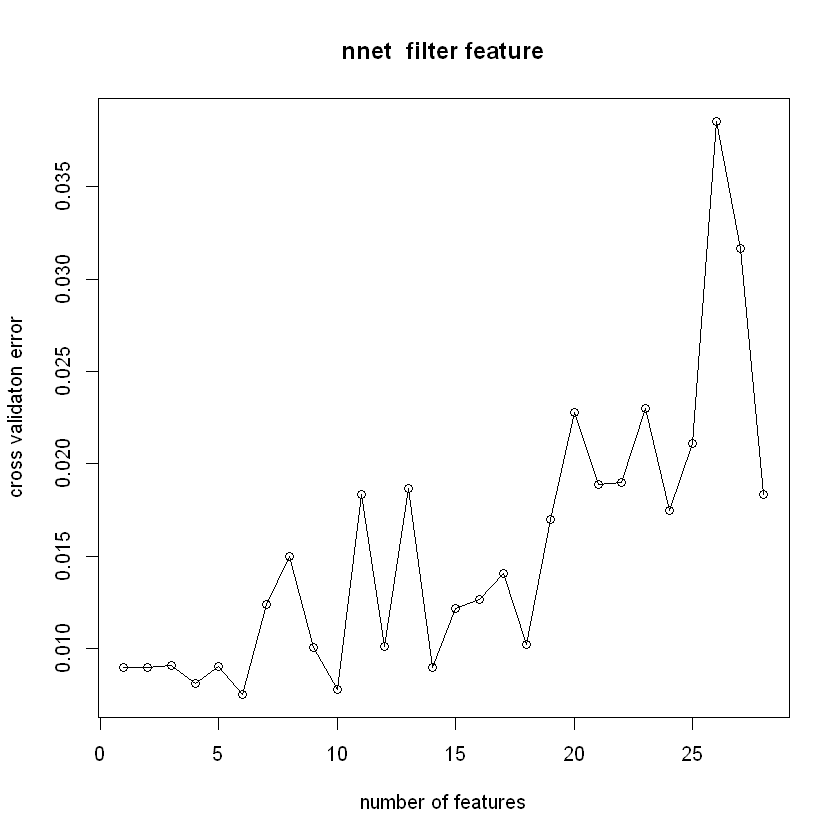

In [105]:
outputCorrelation('nnet', X, Y)#6  ; CV error= 0.0075  ; std dev= 0.0067

# weights:  10
initial  value 204460.294736 
iter  10 value 168.225223
iter  20 value 102.256629
iter  30 value 87.954774
iter  40 value 87.365095
iter  50 value 87.258708
final  value 87.257415 
converged
# weights:  13
initial  value 225209.153510 
iter  10 value 333.302758
iter  20 value 119.276392
iter  30 value 108.936213
iter  40 value 104.057376
iter  50 value 96.523356
iter  60 value 91.637659
iter  70 value 90.918603
iter  80 value 90.414463
iter  90 value 90.224215
iter 100 value 90.177277
iter 110 value 90.140131
iter 120 value 90.125361
final  value 90.125065 
converged
# weights:  16
initial  value 229930.008202 
iter  10 value 294.214619
iter  20 value 99.426598
iter  30 value 91.992269
iter  40 value 87.298854
iter  50 value 84.955875
iter  60 value 79.144878
iter  70 value 76.362357
iter  80 value 75.742765
iter  90 value 73.892114
iter 100 value 73.452836
iter 110 value 73.274127
iter 120 value 72.949839
iter 130 value 72.820411
iter 140 value 72.819229
final  value 72

nnet Features:  1  ; CV error= 0.0093  ; std dev= 0.0079
nnet Features:  2  ; CV error= 0.0106  ; std dev= 0.0083
nnet Features:  3  ; CV error= 0.0098  ; std dev= 0.0088
nnet Features:  4  ; CV error= 0.0093  ; std dev= 0.006
nnet Features:  5  ; CV error= 0.0142  ; std dev= 0.0114
nnet Features:  6  ; CV error= 0.0106  ; std dev= 0.0052
nnet Features:  7  ; CV error= 0.012  ; std dev= 0.0063
nnet Features:  8  ; CV error= 0.007  ; std dev= 0.0073
nnet Features:  9  ; CV error= 0.0115  ; std dev= 0.0088
nnet Features:  10  ; CV error= 0.0124  ; std dev= 0.0071
nnet Features:  11  ; CV error= 0.0118  ; std dev= 0.0134
nnet Features:  12  ; CV error= 0.0094  ; std dev= 0.0077
nnet Features:  13  ; CV error= 0.014  ; std dev= 0.015
nnet Features:  14  ; CV error= 0.0182  ; std dev= 0.0278
nnet Features:  15  ; CV error= 0.0107  ; std dev= 0.0081
nnet Features:  16  ; CV error= 0.0114  ; std dev= 0.0064
nnet Features:  17  ; CV error= 0.0148  ; std dev= 0.0135
nnet Features:  18  ; CV err

[1]  3 15 18  9  5  8 22  6 17 19 12 16  7 20 13 10 21  2  4 24 14  1 28 27 26
[26] 23 25 11

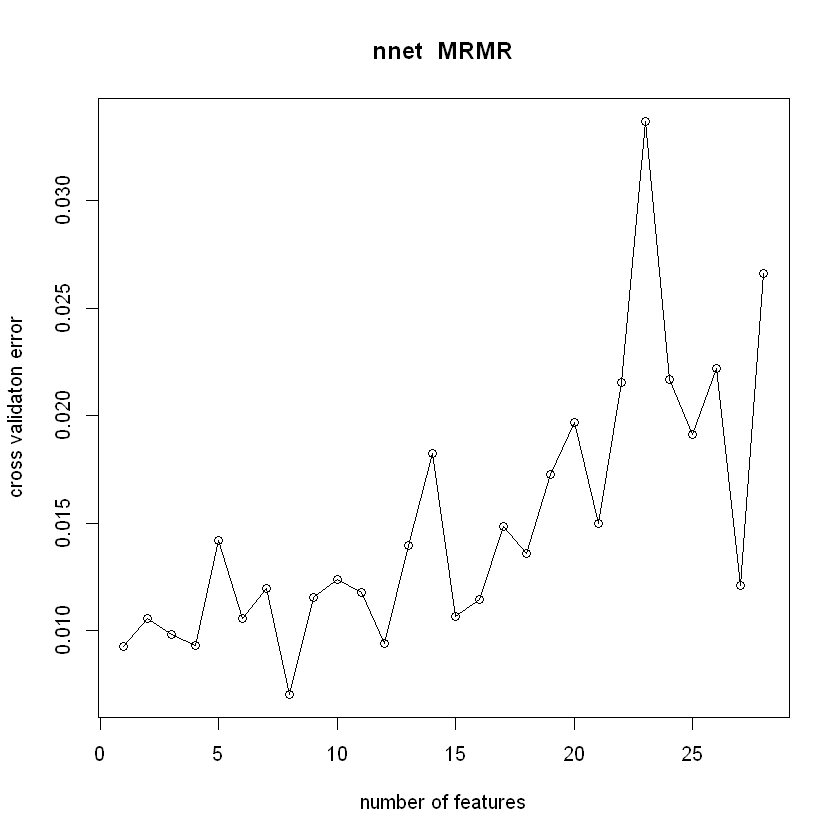

In [106]:
mrmr('nnet', X, Y)#6  ; CV error= 0.0106  ; std dev= 0.0052

# weights:  10
initial  value 205921.833024 
iter  10 value 321.676142
iter  20 value 316.005312
iter  30 value 227.262033
iter  40 value 214.320827
iter  50 value 211.814427
final  value 211.807836 
converged
# weights:  13
initial  value 222315.872845 
iter  10 value 2174.132922
iter  20 value 272.109561
iter  30 value 150.350359
iter  40 value 146.347677
iter  50 value 143.393021
iter  60 value 132.530075
iter  70 value 118.903851
iter  80 value 105.944017
iter  90 value 102.558544
iter 100 value 102.152728
iter 110 value 100.359958
iter 120 value 97.282547
iter 130 value 92.705316
iter 140 value 91.413688
iter 150 value 90.384828
final  value 90.384828 
stopped after 150 iterations
# weights:  16
initial  value 207085.929975 
iter  10 value 5580.915619
iter  20 value 390.598000
iter  30 value 238.952050
iter  40 value 200.477554
iter  50 value 195.291316
iter  60 value 155.287009
iter  70 value 148.762910
iter  80 value 144.649577
iter  90 value 124.753854
iter 100 value 117.539288

nnet  Features:  1  ; CV error= 0.0272  ; std dev= 0.0139
nnet  Features:  2  ; CV error= 0.0155  ; std dev= 0.0118
nnet  Features:  3  ; CV error= 0.0192  ; std dev= 0.0148
nnet  Features:  4  ; CV error= 0.0223  ; std dev= 0.0134
nnet  Features:  5  ; CV error= 0.0261  ; std dev= 0.0131
nnet  Features:  6  ; CV error= 0.0266  ; std dev= 0.0175
nnet  Features:  7  ; CV error= 0.0167  ; std dev= 0.0155
nnet  Features:  8  ; CV error= 0.0291  ; std dev= 0.0217
nnet  Features:  9  ; CV error= 0.026  ; std dev= 0.0171
nnet  Features:  10  ; CV error= 0.0269  ; std dev= 0.0129
nnet  Features:  11  ; CV error= 0.0261  ; std dev= 0.0186
nnet  Features:  12  ; CV error= 0.0263  ; std dev= 0.0146
nnet  Features:  13  ; CV error= 0.0297  ; std dev= 0.0216
nnet  Features:  14  ; CV error= 0.0258  ; std dev= 0.0174
nnet  Features:  15  ; CV error= 0.0306  ; std dev= 0.0229
nnet  Features:  16  ; CV error= 0.0263  ; std dev= 0.0168
nnet  Features:  17  ; CV error= 0.0221  ; std dev= 0.0141
nnet  F

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28
-2065.8900,113.85792,24.586513,263.0594,114.39025,-35.967129,-98.251314,-22.2560031,8.990474,-33.5365523,...,0.26268057,-0.32928352,-0.085160242,-0.808687722,-0.58202540,-0.15388255,-0.06789207,-0.28058861,-0.147156777,0.091651860
-917.7324,-80.56675,56.802650,-311.9055,-49.13928,79.873186,212.212160,25.3229159,27.979274,-0.4423117,...,2.30582469,0.75705743,0.161850748,0.534085294,0.85509626,-0.09937444,-0.32991551,-0.06858620,-0.807748581,-0.044661437
735.5653,164.30915,26.020406,255.8353,121.88086,22.539030,-108.322870,-3.6573112,25.796962,-35.5229479,...,-0.86127232,0.18791607,-0.136872700,0.371886289,-0.71567372,-0.18235727,0.07821528,-0.39044196,-0.074871819,-0.059361191
-967.1986,32.43104,29.024820,356.4721,99.80322,180.994055,-119.487512,181.4764056,-150.502830,69.9779698,...,-0.56776510,-1.69592686,-0.383220813,0.170613523,-0.72926330,-0.46643076,-0.58519234,0.72619215,-0.004393291,0.029657255
3755.0246,646.20113,-4.414097,287.3848,299.36128,-12.543443,34.891324,-6.8893584,-6.894942,-19.3498927,...,0.42096196,-0.37434265,-0.173959806,0.042741958,-0.76939988,-0.04997115,-0.02258472,0.01591037,0.002187477,0.068953123
3593.3691,-396.23305,-623.857989,113.0340,49.45887,84.884165,-45.015105,-12.0040570,28.844119,-43.2803400,...,-1.77360956,0.85383511,-0.636470994,-1.251402299,-0.32454363,0.45562594,-0.25305965,0.16654138,0.051618656,0.003685003
-421.9633,547.43326,12.800807,-428.3266,17.68638,18.335204,127.213571,4.5786859,1.564227,-12.3106668,...,0.09683866,-0.67060324,0.012558059,0.113361018,-0.27794267,-0.50503013,0.33581921,-0.14752898,-0.003109245,-0.059801635
-125.0050,497.46385,-354.835634,278.4744,-24.62461,-89.219890,102.538322,34.1770727,-241.090290,64.8888847,...,0.34506098,0.54719755,-0.855262469,0.457111901,-0.11863785,-0.19985576,-0.32178093,-0.21113661,-0.006865037,-0.052631585
-4394.0278,212.66759,10.000079,235.3965,-87.98918,96.138450,-9.910449,161.3964922,-82.917976,49.5539440,...,0.20057404,-1.94790289,-1.175946087,-0.159436643,1.21635374,-0.42129946,-0.26656346,-0.23538997,-0.052927745,-0.851166181
-3104.7676,-404.87516,72.281198,-169.3016,-195.33952,-60.925290,-45.907632,-2.9117863,35.995338,-31.7200229,...,0.47553911,-0.22807586,-1.421993519,0.727462660,0.13871272,-0.43802030,-0.03545600,0.03817294,0.070149705,-0.780883386


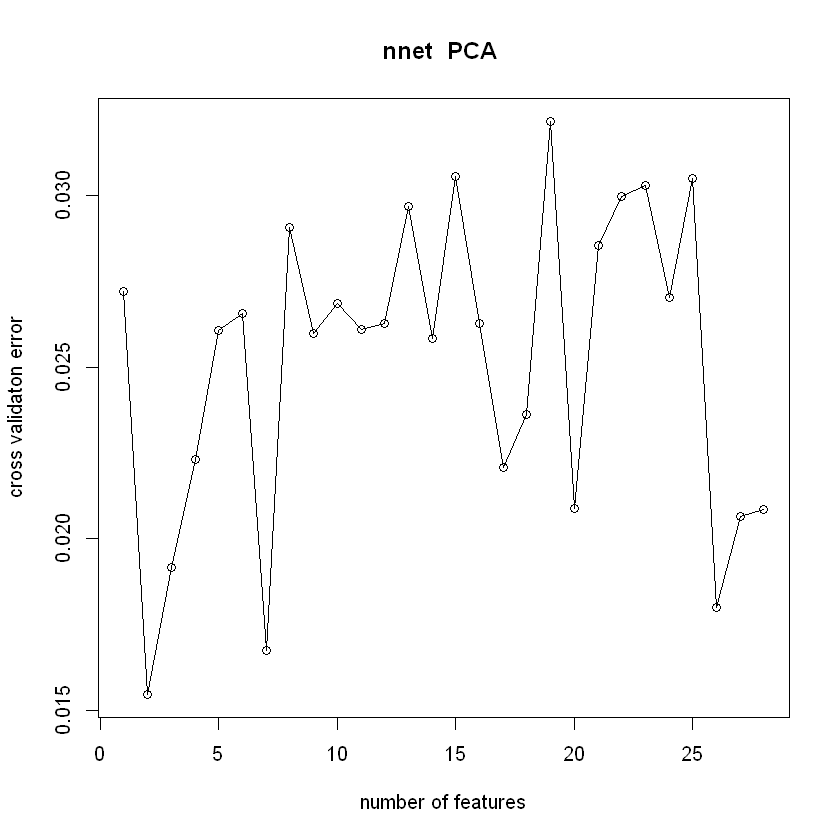

In [107]:
pca('nnet', X, Y)# Features:  2  ; CV error= 0.0155  ; std dev= 0.0118

In [109]:
#forwardSelection('nnet', X, Y) #

In [110]:
runEnsemble('nnet', X, Y) #0.0232  

# weights:  91
initial  value 186900.669312 
iter  10 value 771.364337
iter  20 value 238.245518
iter  30 value 226.986492
iter  40 value 226.325085
iter  50 value 190.414153
iter  60 value 183.667258
iter  70 value 166.959703
iter  80 value 164.275173
iter  90 value 154.849271
iter 100 value 152.570753
iter 110 value 152.200147
iter 120 value 151.980004
iter 130 value 151.492195
iter 140 value 151.381653
iter 150 value 151.106833
final  value 151.106833 
stopped after 150 iterations
# weights:  91
initial  value 216710.050482 
iter  10 value 429.953356
iter  20 value 427.577233
iter  30 value 423.897653
iter  40 value 419.558584
iter  50 value 416.022798
iter  60 value 402.446376
iter  70 value 382.860343
iter  80 value 370.192615
iter  90 value 339.302613
iter 100 value 323.607290
iter 110 value 314.500829
iter 120 value 307.844441
iter 130 value 299.407151
iter 140 value 291.243258
iter 150 value 282.343977
final  value 282.343977 
stopped after 150 iterations
# weights:  91
initial

# weights:  10
initial  value 202154.609534 
iter  10 value 284.428725
iter  20 value 113.835602
iter  30 value 103.895496
iter  40 value 101.393931
iter  50 value 101.388681
final  value 101.387309 
converged
# weights:  13
initial  value 193986.119841 
iter  10 value 215.128637
iter  20 value 111.534275
iter  30 value 90.332364
iter  40 value 85.312566
iter  50 value 73.875957
iter  60 value 67.265114
iter  70 value 67.177173
iter  80 value 67.173507
final  value 67.173067 
converged
# weights:  16
initial  value 201807.688412 
iter  10 value 261.179361
iter  20 value 207.841940
iter  30 value 105.765752
iter  40 value 91.460771
iter  50 value 68.560905
iter  60 value 66.353719
iter  70 value 66.279823
iter  80 value 66.276228
final  value 66.276225 
converged
# weights:  19
initial  value 204212.301650 
iter  10 value 365.563378
iter  20 value 226.554797
iter  30 value 198.908088
iter  40 value 169.638282
iter  50 value 81.538402
iter  60 value 63.317104
iter  70 value 60.310394
ite

nnet  filter features:  1  ; CV error= 0.0094  ; std dev= 0.0086
nnet  filter features:  2  ; CV error= 0.0083  ; std dev= 0.0056
nnet  filter features:  3  ; CV error= 0.0086  ; std dev= 0.0052
nnet  filter features:  4  ; CV error= 0.0095  ; std dev= 0.0053
nnet  filter features:  5  ; CV error= 0.0084  ; std dev= 0.0073
nnet  filter features:  6  ; CV error= 0.0102  ; std dev= 0.0089
nnet  filter features:  7  ; CV error= 0.0078  ; std dev= 0.0058
nnet  filter features:  8  ; CV error= 0.0145  ; std dev= 0.01
nnet  filter features:  9  ; CV error= 0.0175  ; std dev= 0.0243
nnet  filter features:  10  ; CV error= 0.012  ; std dev= 0.0116
nnet  filter features:  11  ; CV error= 0.0137  ; std dev= 0.0148
nnet  filter features:  12  ; CV error= 0.0085  ; std dev= 0.0057
nnet  filter features:  13  ; CV error= 0.0152  ; std dev= 0.0217
nnet  filter features:  14  ; CV error= 0.0181  ; std dev= 0.0137
nnet  filter features:  15  ; CV error= 0.0174  ; std dev= 0.0144
nnet  filter features:

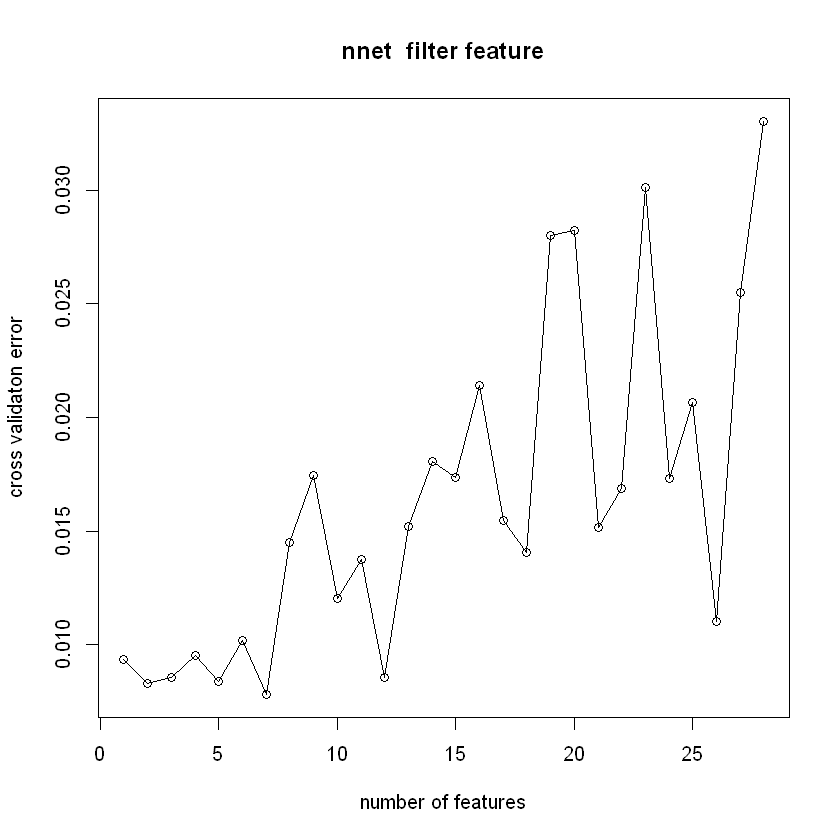

In [111]:
#the winner is
nnetIndexes <- outputCorrelation('nnet', X, Y)
nnetIndexes <- nnetIndexes[1: 6]


In [112]:
runEnsemble('nnet', X[, nnetIndexes], Y)#0.0091  

# weights:  25
initial  value 187706.820252 
iter  10 value 440.706785
iter  20 value 262.118513
iter  30 value 241.125819
iter  40 value 225.071051
iter  50 value 170.183242
iter  60 value 110.360250
iter  70 value 73.875516
iter  80 value 68.391283
iter  90 value 68.104963
iter 100 value 63.409072
iter 110 value 62.044137
iter 120 value 58.520150
iter 130 value 58.173315
iter 140 value 58.158590
iter 150 value 58.157848
final  value 58.157848 
stopped after 150 iterations
# weights:  25
initial  value 193038.045849 
iter  10 value 619.887529
iter  20 value 222.783887
iter  30 value 216.717804
iter  40 value 202.273000
iter  50 value 167.515337
iter  60 value 103.056801
iter  70 value 60.868879
iter  80 value 57.874850
iter  90 value 56.418496
iter 100 value 56.028430
iter 110 value 53.644253
iter 120 value 53.532178
iter 130 value 53.473826
iter 140 value 53.359882
iter 150 value 53.350289
final  value 53.350289 
stopped after 150 iterations
# weights:  25
initial  value 188277.11375

## RIDGE

In [102]:
X<- numeric.df[1:nrow(input),]
runModel('ridge', X, Y) 

[1] "ridge   CV error= 0.0096  ; std dev= 0.0065"


## Compare models 
| Algorithm | RMSE | Features      
| :- |:-|:-
| rpart | 0.0158  |rpartIndexes
| svm |0.0054   |svmIndexes
| lazy |0.0508   |lazyIndexes
| tree |0.0145 | treeIndexes
| lm |0.0028   |lmIndexes
| nnet |0.0091   |nnetIndexes

In [124]:
write(rpartIndexes, 'rpartIndexes.txt', sep =',')
write(svmIndexes, 'svmIndexes.txt', sep =',')
write(lazyIndexes, 'lazyIndexes.txt', sep =',')
write(treeIndexes, 'treeIndexes.txt', sep =',')
write(lmIndexes, 'lmIndexes.txt', sep =',')
write(nnetIndexes, 'nnetIndexes.txt', sep =',')

In [116]:
X<- data[1:nrow(input),]
ensembleSimpleAverage(c('lm'), list(lmIndexes), X, Y) #0.0032  

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Ensemble  lm   CV error= 0.0032  ; std dev= 0.0028"


In [118]:
ensembleSimpleAverage(c('svm'), list(svmIndexes), X, Y) #  0.0054  

[1] "Ensemble  svm   CV error= 0.0054  ; std dev= 0.0041"


In [119]:
ensembleSimpleAverage(c('svm', 'lm'), list(svmIndexes, lmIndexes), X, Y) #6.0124  

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):


[1] "Ensemble  lm   CV error= 6.0124  ; std dev= 0.0163"


In [120]:
ensembleSimpleAverage(c('nnet', 'lm'), list(nnetIndexes, lmIndexes), X, Y)#6.0119  

# weights:  25
initial  value 169471.589424 
iter  10 value 233.088278
iter  20 value 178.090555
iter  30 value 145.638541
iter  40 value 94.897633
iter  50 value 69.433636
iter  60 value 69.027697
iter  70 value 60.746696
iter  80 value 57.239782
iter  90 value 57.125029
iter 100 value 56.919446
iter 110 value 56.289647
iter 120 value 54.208966
iter 130 value 53.049486
iter 140 value 53.027721
iter 150 value 53.011785
final  value 53.011785 
stopped after 150 iterations
# weights:  25
initial  value 193374.432503 
iter  10 value 234.493082
iter  20 value 228.196233
iter  30 value 224.828957
iter  40 value 212.068696
iter  50 value 209.434310
iter  60 value 208.086874
iter  70 value 204.253195
iter  80 value 203.890583
iter  90 value 202.584336
iter 100 value 201.787432
iter 110 value 200.875717
iter 120 value 193.310627
iter 130 value 179.099518
iter 140 value 119.548883
iter 150 value 99.182997
final  value 99.182997 
stopped after 150 iterations
# weights:  25
initial  value 185953.

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

# weights:  25
initial  value 174704.149948 
iter  10 value 230.403600
iter  20 value 218.103349
iter  30 value 174.713906
iter  40 value 119.560870
iter  50 value 84.138759
iter  60 value 79.666499
iter  70 value 74.518168
iter  80 value 64.845704
iter  90 value 63.588562
iter 100 value 62.689422
iter 110 value 61.681488
iter 120 value 61.536252
iter 130 value 61.528642
iter 140 value 61.527807
iter 150 value 61.499757
final  value 61.499757 
stopped after 150 iterations
# weights:  25
initial  value 204167.651961 
iter  10 value 230.233760
iter  20 value 225.886728
iter  30 value 224.448423
iter  40 value 114.752876
iter  50 value 74.600288
iter  60 value 69.300695
iter  70 value 68.745769
iter  80 value 68.662444
iter  90 value 68.505113
iter 100 value 68.497026
iter 100 value 68.497026
final  value 68.497023 
converged
# weights:  25
initial  value 171845.479606 
iter  10 value 343.093861
iter  20 value 231.618995
iter  30 value 180.467243
iter  40 value 146.096320
iter  50 value 7

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

# weights:  25
initial  value 175632.266974 
iter  10 value 363.578329
iter  20 value 143.807021
iter  30 value 91.810304
iter  40 value 58.672685
iter  50 value 57.448046
iter  60 value 53.370813
iter  70 value 51.499909
iter  80 value 51.204395
iter  90 value 51.117126
final  value 51.114478 
converged
# weights:  25
initial  value 170982.103488 
iter  10 value 430.290315
iter  20 value 406.109232
iter  30 value 227.621931
iter  40 value 214.838062
iter  50 value 208.605032
iter  60 value 190.569772
iter  70 value 124.714131
iter  80 value 89.390878
iter  90 value 75.496513
iter 100 value 73.566892
iter 110 value 72.867176
iter 120 value 72.825529
iter 130 value 72.595864
iter 140 value 72.407612
iter 150 value 72.189398
final  value 72.189398 
stopped after 150 iterations
# weights:  25
initial  value 179262.410430 
iter  10 value 219.924813
iter  20 value 188.871110
iter  30 value 121.436608
iter  40 value 77.275792
iter  50 value 59.608118
iter  60 value 53.711021
iter  70 value 5

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

# weights:  25
initial  value 192077.759756 
iter  10 value 218.364167
iter  20 value 175.662288
iter  30 value 73.692922
iter  40 value 58.823048
iter  50 value 58.425722
iter  60 value 56.562570
iter  70 value 56.124700
iter  80 value 55.631381
iter  90 value 55.609067
iter 100 value 55.605476
iter 110 value 55.605144
final  value 55.605141 
converged
# weights:  25
initial  value 201228.664694 
iter  10 value 221.912380
iter  20 value 175.954251
iter  30 value 148.300330
iter  40 value 75.497478
iter  50 value 57.743155
iter  60 value 52.254670
iter  70 value 50.826171
iter  80 value 49.938255
iter  90 value 49.701015
iter 100 value 49.110246
iter 110 value 48.717772
iter 120 value 48.599582
iter 130 value 48.584376
iter 140 value 48.570487
iter 150 value 48.565840
final  value 48.565840 
stopped after 150 iterations
# weights:  25
initial  value 227420.453590 
iter  10 value 416.677133
iter  20 value 233.077320
iter  30 value 218.711537
iter  40 value 202.518095
iter  50 value 149.

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

# weights:  25
initial  value 180719.370979 
iter  10 value 336.523022
iter  20 value 122.433522
iter  30 value 68.911838
iter  40 value 56.815681
iter  50 value 55.424378
iter  60 value 54.998993
iter  70 value 54.886657
iter  80 value 54.551929
iter  90 value 54.489616
final  value 54.457705 
converged
# weights:  25
initial  value 194920.442716 
iter  10 value 304.382201
iter  20 value 272.891844
iter  30 value 184.259032
iter  40 value 144.372276
iter  50 value 104.556231
iter  60 value 72.121669
iter  70 value 66.215234
iter  80 value 65.157770
iter  90 value 65.085492
iter 100 value 58.971867
iter 110 value 57.693316
iter 120 value 56.583457
iter 130 value 54.438796
iter 140 value 52.774228
iter 150 value 51.723421
final  value 51.723421 
stopped after 150 iterations
# weights:  25
initial  value 191241.587880 
iter  10 value 199.663262
iter  20 value 181.434856
iter  30 value 107.129345
iter  40 value 70.068495
iter  50 value 58.059844
iter  60 value 53.821918
iter  70 value 52.

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

# weights:  25
initial  value 165251.615985 
iter  10 value 213.352684
iter  20 value 207.164713
iter  30 value 155.213807
iter  40 value 108.050025
iter  50 value 63.818388
iter  60 value 56.812327
iter  70 value 54.854479
iter  80 value 54.351032
iter  90 value 53.285278
iter 100 value 51.173378
iter 110 value 50.349333
iter 120 value 50.197705
iter 130 value 50.195535
iter 140 value 50.195259
final  value 50.195084 
converged
# weights:  25
initial  value 198281.385975 
iter  10 value 250.314577
iter  20 value 210.357726
iter  30 value 190.646060
iter  40 value 165.152343
iter  50 value 152.722380
iter  60 value 81.246031
iter  70 value 69.935401
iter  80 value 66.325775
iter  90 value 57.585007
iter 100 value 56.295588
iter 110 value 56.168505
iter 120 value 56.097192
iter 130 value 56.078559
iter 140 value 56.074468
final  value 56.074464 
converged
# weights:  25
initial  value 194757.601038 
iter  10 value 412.244305
iter  20 value 333.431348
iter  30 value 130.318057
iter  40 v

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

# weights:  25
initial  value 162030.513723 
final  value 233.922453 
converged
# weights:  25
initial  value 187390.370033 
iter  10 value 273.188423
iter  20 value 268.904246
iter  30 value 247.917210
iter  40 value 168.807589
iter  50 value 123.496111
iter  60 value 109.450254
iter  70 value 94.211076
iter  80 value 92.661883
iter  90 value 92.268367
iter 100 value 92.191566
iter 110 value 92.097530
iter 120 value 91.839624
iter 130 value 91.692364
iter 140 value 91.483576
iter 150 value 91.401939
final  value 91.401939 
stopped after 150 iterations
# weights:  25
initial  value 224950.050493 
iter  10 value 226.138850
iter  20 value 190.121375
iter  30 value 166.207789
iter  40 value 82.823467
iter  50 value 73.189532
iter  60 value 59.271493
iter  70 value 58.866541
iter  80 value 58.809248
iter  90 value 58.450770
iter 100 value 56.987281
iter 110 value 56.016435
iter 120 value 54.060711
iter 130 value 52.673828
iter 140 value 52.256767
iter 150 value 51.186086
final  value 51.18

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

# weights:  25
initial  value 181337.954962 
iter  10 value 208.731415
iter  20 value 181.291643
iter  30 value 135.931705
iter  40 value 111.760097
iter  50 value 100.175104
iter  60 value 68.806095
iter  70 value 57.642518
iter  80 value 56.205930
iter  90 value 55.225122
iter 100 value 54.632979
iter 110 value 54.590509
iter 120 value 54.546951
iter 130 value 54.537734
final  value 54.537413 
converged
# weights:  25
initial  value 186286.600074 
iter  10 value 373.031521
iter  20 value 219.472441
iter  30 value 217.899371
iter  40 value 210.430139
iter  50 value 180.954233
iter  60 value 152.263211
iter  70 value 101.024658
iter  80 value 72.412178
iter  90 value 64.968643
iter 100 value 63.631547
iter 110 value 62.965014
iter 120 value 62.933234
final  value 62.931436 
converged
# weights:  25
initial  value 204503.308565 
iter  10 value 441.788661
iter  20 value 423.380034
iter  30 value 99.903714
iter  40 value 77.440981
iter  50 value 63.905688
iter  60 value 61.766387
iter  70

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

# weights:  25
initial  value 209394.269441 
iter  10 value 253.344975
iter  20 value 240.079464
iter  30 value 204.994161
iter  40 value 192.906579
iter  50 value 154.502578
iter  60 value 84.819574
iter  70 value 59.296323
iter  80 value 56.943245
iter  90 value 56.148509
iter 100 value 53.737816
iter 110 value 52.041944
iter 120 value 51.478832
iter 130 value 49.238113
iter 140 value 49.155108
iter 150 value 48.746581
final  value 48.746581 
stopped after 150 iterations
# weights:  25
initial  value 209122.439260 
iter  10 value 255.851737
iter  20 value 253.139626
iter  30 value 224.558123
iter  40 value 207.677562
iter  50 value 191.700918
iter  60 value 132.103787
iter  70 value 89.482302
iter  80 value 82.199088
iter  90 value 72.642817
iter 100 value 68.262493
iter 110 value 67.721454
iter 120 value 67.222623
iter 130 value 67.104486
iter 140 value 67.094921
final  value 67.092691 
converged
# weights:  25
initial  value 222202.304183 
iter  10 value 819.791527
iter  20 value 2

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

# weights:  25
initial  value 201095.630452 
iter  10 value 320.234671
iter  20 value 256.249134
iter  30 value 229.112929
iter  40 value 219.682627
iter  50 value 172.136980
iter  60 value 120.934067
iter  70 value 78.668916
iter  80 value 70.559484
iter  90 value 69.434326
iter 100 value 69.123112
iter 110 value 69.024130
iter 120 value 68.777353
iter 130 value 68.462855
iter 140 value 68.417341
final  value 68.417305 
converged
# weights:  25
initial  value 177321.607321 
iter  10 value 346.389457
iter  20 value 282.012526
iter  30 value 237.072008
iter  40 value 122.429928
iter  50 value 97.290825
iter  60 value 86.061696
iter  70 value 71.182364
iter  80 value 68.985635
iter  90 value 67.851007
iter 100 value 67.648628
iter 110 value 66.851437
iter 120 value 65.895511
iter 130 value 65.166848
iter 140 value 64.192549
iter 150 value 61.962513
final  value 61.962513 
stopped after 150 iterations
# weights:  25
initial  value 221154.110189 
iter  10 value 271.406542
iter  20 value 24

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Ensemble  lm   CV error= 6.0119  ; std dev= 0.0163"


In [121]:
ensembleSimpleAverage(c('svm', 'nnet'), list(svmIndexes,nnetIndexes), X, Y)

# weights:  124
initial  value 206734.023432 
iter  10 value 639.356470
iter  20 value 199.685637
iter  30 value 189.944505
iter  40 value 163.650063
iter  50 value 139.335754
iter  60 value 125.843891
iter  70 value 75.206854
iter  80 value 63.581524
iter  90 value 61.393000
iter 100 value 58.504998
iter 110 value 55.708107
iter 120 value 54.571261
iter 130 value 53.841927
iter 140 value 49.877345
iter 150 value 46.267952
final  value 46.267952 
stopped after 150 iterations
# weights:  124
initial  value 191995.532367 
iter  10 value 229.246849
iter  20 value 220.363393
iter  30 value 208.739447
iter  40 value 204.567835
iter  50 value 187.736030
iter  60 value 121.465521
iter  70 value 105.840892
iter  80 value 70.203275
iter  90 value 52.837200
iter 100 value 51.207803
iter 110 value 50.931739
iter 120 value 50.270072
iter 130 value 46.967098
iter 140 value 44.689225
iter 150 value 44.096664
final  value 44.096664 
stopped after 150 iterations
# weights:  124
initial  value 153980.6

In [122]:
ensembleSimpleAverage(c('nnet', 'nnet'), list(nnetIndexes,nnetIndexes), X, Y)

# weights:  25
initial  value 205093.888160 
iter  10 value 552.901883
iter  20 value 475.987370
iter  30 value 411.474842
iter  40 value 90.209788
iter  50 value 77.226312
iter  60 value 67.765567
iter  70 value 62.895969
iter  80 value 61.927185
iter  90 value 61.354579
iter 100 value 59.508810
iter 110 value 59.122141
final  value 59.122019 
converged
# weights:  25
initial  value 180980.596364 
iter  10 value 377.930392
iter  20 value 371.355859
iter  30 value 188.283004
iter  40 value 130.190773
iter  50 value 110.116620
iter  60 value 75.157552
iter  70 value 56.575200
iter  80 value 54.881223
iter  90 value 54.564760
iter 100 value 54.439117
iter 110 value 54.417010
iter 120 value 54.415129
final  value 54.415104 
converged
# weights:  25
initial  value 193580.909532 
iter  10 value 264.683589
iter  20 value 235.068460
iter  30 value 205.983255
iter  40 value 167.471340
iter  50 value 131.805281
iter  60 value 94.994632
iter  70 value 76.958120
iter  80 value 67.438430
iter  90 

In [123]:
ensembleSimpleAverage(c('nnet'), list(nnetIndexes), X, Y)

# weights:  25
initial  value 207811.489137 
iter  10 value 236.335801
iter  20 value 223.773249
iter  30 value 220.001782
iter  40 value 169.139274
iter  50 value 83.942675
iter  60 value 69.053979
iter  70 value 63.041165
iter  80 value 62.185008
iter  90 value 61.509561
iter 100 value 57.506904
iter 110 value 57.094635
iter 120 value 56.615497
iter 130 value 55.780603
iter 140 value 55.760500
iter 150 value 55.758537
final  value 55.758537 
stopped after 150 iterations
# weights:  25
initial  value 198010.460943 
iter  10 value 2730.084048
iter  20 value 2125.000358
iter  30 value 237.129069
iter  40 value 222.923797
iter  50 value 180.653514
iter  60 value 143.640371
iter  70 value 69.810626
iter  80 value 63.683630
iter  90 value 62.705948
iter 100 value 62.107306
iter 110 value 61.084090
iter 120 value 60.857412
iter 130 value 60.348473
iter 140 value 60.321844
final  value 60.321745 
converged
# weights:  25
initial  value 226558.785444 
iter  10 value 221.683307
iter  20 value 

### Create cross validated models

### Prediction

In [91]:
ensemblePrediction <- function(models, modelFeatures, X){
  
  R<-10
  size.CV<-floor(N/10)
  
  CV.err<-numeric(10)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  ### Complete the code. i.ts should be the indices of the tessefor the i-th fold
    X.ts<-X[i.ts,]  
    
    i.tr<-setdiff(1:N,i.ts)                ### Complete the code. i.tr should be the indices of the training sefor the i-th fold
    Y.hat.ts.R<-matrix(0,nrow=nrow(X.ts),ncol= R * length(models))
    
    for( mi in 1: length(models)){
      modelName = models[mi]
      for (r in 1:R) {
        index <- (mi -1 ) * R + r
        
        i.tr.resample<-sample(i.tr,rep=T)
        X.tr<-X[i.tr.resample,]
        Y.tr<-Y[i.tr.resample]       
        
        #for each model feature, use its optimised features
        if(!is.null(modelFeatures)) {
          X.tr <- X.tr[, modelFeatures[[mi]]]
        }
        
        DS<-cbind(X.tr,SalePrice=Y.tr)
        
        if(modelName == 'lm') {
          model<- lm(SalePrice~.,DS)
          Y.hat.ts.R[, r] <- predict(model,X.ts)
        }
        if(modelName == 'rpart') {
          model<- rpart(SalePrice~.,DS)
          Y.hat.ts.R[,index] <- predict(model,X.ts)
        }
        if(modelName == 'tree') {
          model<- tree(SalePrice~.,DS)
          Y.hat.ts.R[,r] <- predict(model,X.ts)
        }
        if(modelName == 'svm'){
          # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
          #             shrinking = T, cross = 10, cost = 4, epislon = 0.2)
          model<- svm(SalePrice~.,DS)
          Y.hat.ts.R[,r] <- predict(model,X.ts)
        }
        if(modelName == 'nnet'){
          #DS <- scale(DS)
          model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3)
          Y.hat.ts.R[,r] <- predict(model,X.ts)
        }
        if(modelName == 'lazy'){
          model<- lazy(SalePrice~.,DS)
          Y.hat.ts.R[,r]<- predict(model,X.ts)$h
        }
        
        if(modelName == 'ridge'){
          model<- linearRidge(SalePrice~.,DS)
          Y.hat.ts.R[,r] <- predict(model,X.ts)
        }
      }
    }
    
    Y.hat.ts<-apply(Y.hat.ts.R,1,mean)

  }
  print('Prediction done')
  Y.hat.ts
}

The following method writes to submission.csv the result outputed by given selection.

It recalculates original price as we transformed y = log(y_i + 1)

In [79]:
writePredictionToFile <- function (prediction) {
  predictedSalePrice <- exp(prediction) -1
  result <- cbind(Id = output$Id, SalePrice = predictedSalePrice )
  colnames(result) <- c("Id","SalePrice")
  write.csv(result, "submission.csv",row.names=FALSE)
}


In [80]:
model<- rpart(SalePrice~.,train)
prediction<- predict(model,test)

In [81]:
writePredictionToFile(prediction)